# CCA Summer School Module - Periodicity Searches

This notebook is prepared by Viraj Karambelkar (vk2588@columbia.edu) for the LSST CCA Summer School 2025, conducted at the Center for Computational Astrophysics from July 28 to August 8, 2025.

## Introduction
Periodic signals are ubiquitous in astronomy. In addition to variable stars, periodic modulations in brightness are also exhibited by binary systems. Some of the most spectacular transient eruptions that we see have binary star progenitors, and as such, finding such binaries and characterizing them can provide heaps of information about how binary stars evolve and the fun explosions they undergo. 

The first part of the module is dedicated to period-finding techniques with a focus on the Lomb Scargle periodogram. This is followed by two activities, where you will analyze real data and study the progenitors of classical novae and red novae from the Milky Way.


## Learning Objectives
- Review the basics of period-finding and Fourier Transforms. 
- Explore different features of the Lomb-Scargle periodogram, and understand its applicability and limitations.
- Gain a cursory understanding of the variety of period-finding algorithms used in astronomy.
- Understand the challenges associated with period finding in real data from time-domain surveys.
- Learn how to detect period changes in data.
- Understand the capabilities of LSST for period-detection, and brainstorm ideas for periodicity searches in the LSST era.



## Resources
This notebook draws heavily from the excellent review of [Lomb Scargle periodograms](https://iopscience.iop.org/article/10.3847/1538-4365/aab766) by Jacob VanderPlas and this notebook from the [LSSTC DSFP school](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Sessions/Session06/Day1/ExtractingPeriodicSignals.ipynb). Additional references and material is listed throughout this notebook

## Required Packages
numpy, matplotlib, astropy, pandas
If you already have these packages installed, try executing the next cell - if you get no errors, your imports are likely good to go. If not, try installing these preferred versions with `pip`.

Preferred versions : <br>
numpy >=2.0.0 <br>
matplotlib>=3.10.0 <br>
astropy >= 7.0.0 <br>
pandas >= 2.2.1

## External files
Provided in the `files` subdirectory:
```
files/nyquist_sampling.png
files/v1309sco_oc_curve.png
files/V1674_her_ztf_fps.dat
files/V1674_her_aavso.dat
files/v1309sco_OGLE_VEGA_AB.txt
files/ztf_eclipsing_binary.fits
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
from astropy.timeseries import LombScargle
from astropy.table import Column
import pandas as pd
%matplotlib inline
import matplotlib


def init():
    """
    A function to set matplotlib parameters so the plots look decent.
    """
    matplotlib.rcParams['xtick.minor.size'] = 6
    matplotlib.rcParams['xtick.major.size'] = 8
    matplotlib.rcParams['ytick.major.size'] = 8
    matplotlib.rcParams['ytick.minor.size'] = 6
    matplotlib.rcParams['lines.linewidth'] = 1.0
    matplotlib.rcParams['axes.linewidth'] = 1.0
    matplotlib.rcParams['font.size']= 18
    matplotlib.rcParams['font.family']= 'sans-serif'
    matplotlib.rcParams['xtick.major.width']= 1.5
    matplotlib.rcParams['ytick.major.width']= 1.5
    matplotlib.rcParams['ytick.direction']='in'
    matplotlib.rcParams['xtick.direction']='in'

init()

## 1. Periodic signals, sampling, fourier transforms

Problem 1a : Write a function that simulates a sinusoidal signal for a given array of time values, taking the amplitude, period, noise-level (standard deviation of noise), mean value of the signal, and phase as arguments. Your function should return the signal and the associated uncertainty.

In [67]:
def simulate_sinusoidal_signal(times, amplitude=1.0, period_days=10.0,
                               noise_level=0.1, mean_value=0.0, phase=0.0):
    """
    Simulate a sinusoidal signal with added Gaussian noise.

    Parameters:
        times (np.ndarray): Array of time values.
        amplitude (float): Amplitude of the sinusoidal signal.
        period_days (float): Period of the sinusoidal signal in days.
        noise_level (float): Standard deviation of the Gaussian noise.
        mean_value (float): Mean value of the signal.
        phase (float): Phase shift of the sinusoidal signal in radians.

    Returns:
        np.ndarray: Simulated signal values with noise.
        np.ndarray: signal uncertainties (same as noise_level).
    """
    sinusoidal_signal = amplitude * np.sin(2 * np.pi * (times / period_days) + phase) + mean_value
    noise = np.random.normal(0, noise_level, size=times.shape)
    signal_with_noise = sinusoidal_signal + noise
    uncertainties = np.full_like(times, noise_level, dtype=float)
    return signal_with_noise, uncertainties

Problem 1b : Write a function to phase-fold a signal at a given period, with the time-array, signal, and period as arguments. Your function should return the phase and the signal

In [7]:
def phase_fold_data(times, signal, period):
    """
    Phase-fold the data at a given period.

    Parameters:
        times (np.ndarray): Array of time values.
        signal (np.ndarray): Array of signal values.
        period (float): Period to phase-fold the data.

    Returns:
        np.ndarray: Phase-folded time values.
        np.ndarray: Phase-folded signal values.
    """
    phase = (times % period) / period
    
    return phase, signal

Problem 1c : Simulate! Simulate and plot a sinusoidal signal with amplitude 1.0, period = 10 days, and standard deviation of noise = 0.1. Also overplot plot the true signal on top.

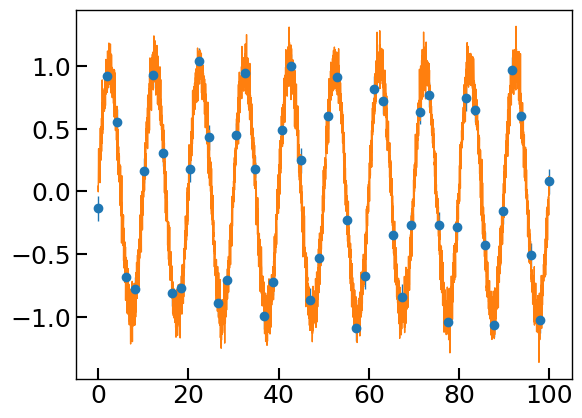

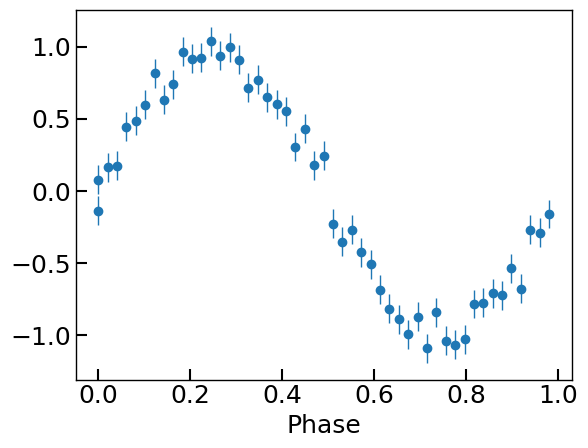

In [20]:
# Simulate the signal using your function
times_days = np.linspace(0, 100, 50)  # Simulate 50 data points from 0 to 100 days
sig = simulate_sinusoidal_signal(times_days, amplitude=1.0, period_days=10.0, noise_level=0.1)

plt.errorbar(times_days, sig[0], yerr=sig[1], fmt='o', label='Simulated Signal')
# plt.show()

times_dense = np.linspace(0, 100, 5000)  # Simulate 50 data points from 0 to 100 days
true_sig = simulate_sinusoidal_signal(times_dense, amplitude=1.0, period_days=10.0)

plt.plot(times_dense, true_sig[0])
plt.show()

phase_folded_times, phase_folded_signal = phase_fold_data(times_days, sig[0], period=10.0)

plt.errorbar(phase_folded_times, phase_folded_signal, yerr=sig[1], fmt='o', label='Simulated Signal')
plt.xlabel('Phase')
plt.show()


How frequently does the signal need to be sampled in order to uniquely determine the period?

Problem 1d : Simulate a signal with a period of 20 days, amplitude of 1, and noise level of 0. Sample the signal at different cadences (e.g., every 2, 5, 10, and 20 days, every 2 days, etc.) and plot the results.
Also plot the true sinusoidal signal for periods of 5, 10, and 20 days on the same plot.

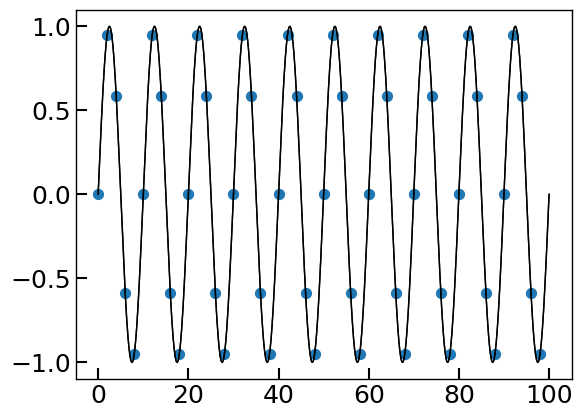

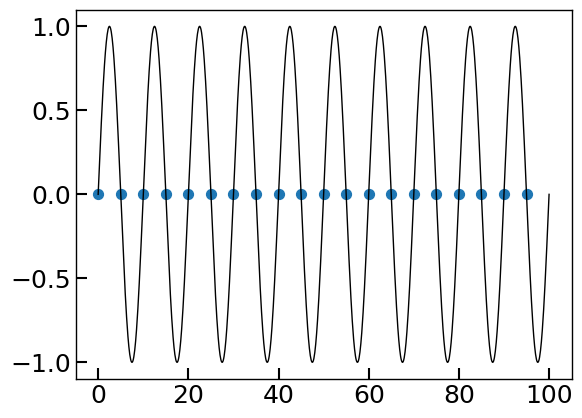

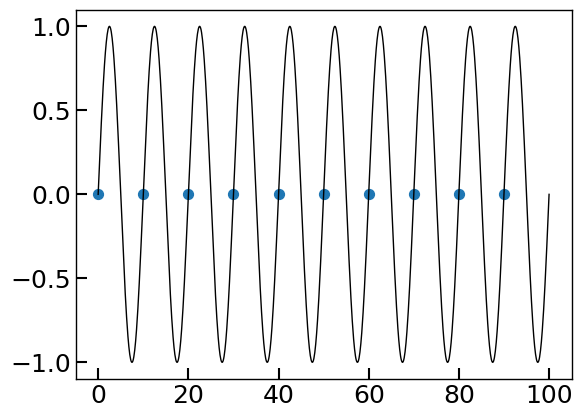

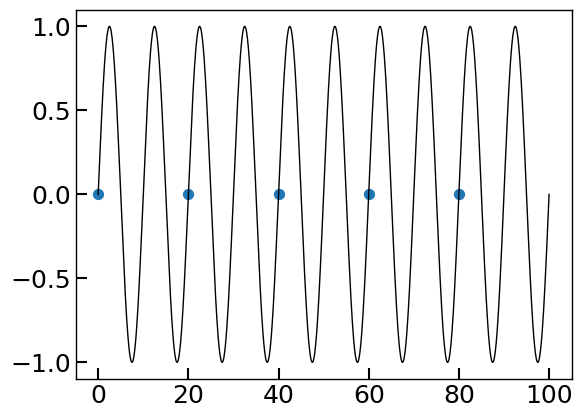

In [25]:
times_days = np.linspace(0, 100, 1000)
cadences = [2, 5, 10, 20]  # Different cadences in days

period = 10.0  # True period of the signal

true_sig = simulate_sinusoidal_signal(times_days, amplitude=1.0, period_days=period, noise_level=0.0)

plt.plot(times_days, true_sig[0], label='True Signal', color='black')

for cadence in cadences:
    cadenced_days = np.arange(0, 100, cadence)
    cadenced_sig = simulate_sinusoidal_signal(cadenced_days, amplitude=1.0, period_days=period, noise_level=0.0)
    
    plt.plot(times_days, true_sig[0], label='True Signal', color='black')
    plt.scatter(cadenced_days, cadenced_sig[0], label=f'Cadence {cadence} days', s=50)
    plt.show()
    

The Nyquist frequency is the minimum sampling rate required to uniquely recover the true period. This frequency is two times the highest frequency present in the signal. For a sinusoidal signal with a period of P days, the Nyquist frequency is 2/P days^-1, meaning we need to sample at least every P/2 days in order to uniquely determine the period.

To understand the origin of Nyquist frequency, let us briefly recall Fourier analysis -

Given a continuous signal, $g(t)$ the Fourier transform of that signal is defined as:

$$\hat{\mathrm{g}}(f) = \int_{-\infty}^{\infty} g(t) \,e^{-2\pi i f t} \,dt,$$

where $i$ is an imaginary number. The inverse of this equation is defined as:

$$ g(t) = \int_{-\infty}^{\infty} \hat{\mathrm{g}}(f) \,e^{-2\pi i f t} \,dt.$$

For convenience, we will use the Fourier transform operator $\mathcal{F}$, from which the above equations reduce to:

$$\mathcal{F}(g) = \hat g$$

$$\mathcal{F}^{-1}(\hat{g}) = g$$

My favorite aspect of Fourier transforms is the convolution theorem. Fourier transforms convert convolutions into point-wise products. The convolution is defined as:

$$ [f \ast g] (t) = \int_{-\infty}^{\infty} f(\tau) \,g(t - \tau) \,d\tau,$$

where $\ast$ is the convolution symbol. From the convolution theorem:

$$ \mathcal{F} \{f \ast g\} = \mathcal{F}(f)  \mathcal{F}(g) $$

Furthermore, the Fourier transform of a product is equal to the convolution of the Fourier transforms:

$$ \mathcal{F}\{f \cdot g\} = \mathcal{F}(f) \ast \mathcal{F}(g) $$

This property is very important for astrophysical observations, that can be described as a product of a continuous signal with a discrete sampling function. In the frequency space, the fourier transform of the observations is a convolution of the fourier transforms of the continuous signal and the sampling function.

Here's an example (taken from [Van der Plas 2017](https://arxiv.org/abs/1703.09824)) -

![Fig. 3 from Van der Plas 2017](files/nyquist_sampling.png)

This simple picture shows that for a signal sampled at a frequency $f_{0}$ to be fully recoverable, its frequencies should be band-limited within $\pm f_{0}/2$. In other words, the highest frequency that can be detected in such data is $f_{0}/2$.


Problem 1e : Note that the all our discussion so far has dealt data that is evenly sampled. In practice, astronomical data is often unevenly sampled due to various factors such as weather conditions, scheduling constraints, and observational limitations. How would this picture change if the data are unevenly sampled? What if the sampling is random? We will return to this question shortly.

## 2. Identifying periodic signals using periodograms
Fourier transforms are great, but what we really want is a way to take time-series observations and identify the likely dominant frequency(ies) in them. From our discussion on Fourier transforms, we can define the power spectral density or power spectrum:

$$ \mathcal{P}_g = \left|\mathcal{F}(g)\right|^2.$$

The power spectrum is a real-valued function that quantifies the contribution of each frequency $f$ to the total signal in $g$. The power spectrum thus provides a way to identify the dominant frequency in any given signal.

For non-continuous observations, we can (but won't here) derive the discrete Fourier transform for evenly sampled data -

$$ \hat g_\mathrm{obs}(f) = \sum_{n = 0}^N g_n\,e^{-2\pi i f n\Delta t}$$

where $g_n = g(n\Delta t)$, and $\Delta t$ is the sampling interval. Our discussion of the Nyquist frequency tells us that we cannot detect frequencies $f > 1/2\Delta T$. Thus, the relevant frequencies to search for power given $\Delta t$ are between 0 and $f_\mathrm{Ny}$, which we can sample on a grid $\Delta f = 1/(N \Delta t)$. From there:

$$\hat g_k = \sum_{n = 0}^N g_n\,e^{-2\pi i f knN}$$

where $\hat g_k = \hat g_\mathrm{obs} (k\Delta f)$. This is the discrete Fourier transform.

Its associated periodogram (an estimator of the power spectrum) is given by:

$$\mathcal{P}(f) = \frac{1}{N}\left|\sum_{n=1}^{N} g_n\,e^{-2\pi i f knN}\right|^2$$

which is also called the classical periodogram or the Schuster periodogram (Schuster 1898).

The Lomb-Scargle periodogram (pioneered by [Lomb 1976](https://ui.adsabs.harvard.edu/abs/1976Ap%26SS..39..447L/abstract) and [Scargle 1982](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract), and explained nicely in [Van der Plas 2017](https://arxiv.org/abs/1703.09824)) is a generalized form of the classical periodogram that can deal with unevenly sampled data. The main properties of the Lomb-Scargle periodogram are:
- It can handle unevenly sampled data, making it suitable for astronomical time-series data.
- It reduces to the classical periodogram for evenly sampled data.
- Its statistics are analytically computable.

and finally, a truly spectacular derivation,

- It can be shown that the Lomb-Scargle periodogram is identical to fitting a simple sinusoidal model at each frequency to the data and constructing a "periodogram" using a $\chi^{2}$ goodness-of-fit statistic. This means that the Lomb-Scargle periodogram analysis can be interpreted as a measure of how well a single sinusoidal model fits the data.

Please refer to [Van der Plas 2017](https://arxiv.org/abs/1703.09824) (and [Lomb 1976](https://ui.adsabs.harvard.edu/abs/1976Ap%26SS..39..447L/abstract) and [Scargle 1982](https://ui.adsabs.harvard.edu/abs/1982ApJ...263..835S/abstract) if you are feeling particularly brave) for a detailed derivation, explanation, and applications of the Lomb-Scargle periodogram and its applications. You can also refer to this excellent notebook from the [LSSTC DSFP school](https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/main/Sessions/Session06/Day1/ExtractingPeriodicSignalsSolutions.ipynb) to try and implement Lomb-Scargle from scratch.

Here, in true observational astronomer spirit, we will dive directly into the deep end using the astropy implementation `LombScargle`.


Problem 2a : Examine the documentation for `astropy.timeseries.LombScargle`

In [30]:
LombScargle.autopower?

Signature:
LombScargle.autopower(
    self,
    method='auto',
    method_kwds=None,
    normalization=None,
    samples_per_peak=5,
    nyquist_factor=5,
    minimum_frequency=None,
    maximum_frequency=None,
)
Docstring:
Compute Lomb-Scargle power at automatically-determined frequencies.

Parameters
----------
method : str, optional
    specify the lomb scargle implementation to use. Options are:

    - 'auto': choose the best method based on the input
    - 'fast': use the O[N log N] fast method. Note that this requires
      evenly-spaced frequencies: by default this will be checked unless
      ``assume_regular_frequency`` is set to True.
    - 'slow': use the O[N^2] pure-python implementation
    - 'cython': use the O[N^2] cython implementation. This is slightly
      faster than method='slow', but much more memory efficient.
    - 'chi2': use the O[N^2] chi2/linear-fitting implementation
    - 'fastchi2': use the O[N log N] chi2 implementation. Note that this
      requires eve

Problem 2b :
- Simulate a sinusoidal signal with a period of 20 days, amplitude of 1, and noise level of 0.1, with a cadence of 2 days.
- Compute and plot the `LombScargle` periodogram using `LombScargle.autopower()`.
Do not provide any arguments to `autopower`.
- Mark the Nyquist frequency for the data on your plot.

(Side note : Generally, periodograms are plotted as power vs frequency. I find it more intuitive to plot them as power vs period. Either choice is fine, but make sure you are consistent and label your axes everywhere!)

In [68]:
simulate_sinusoidal_signal(cadenced_days, amplitude=1.0, period_days=20, noise_level=0.1)

(array([ 0.06771504,  0.59778193,  1.03103816,  0.8266282 ,  0.46953834,
        -0.10925052, -0.6001427 , -1.00029641, -0.90527945, -0.57831411,
         0.02384125,  0.66980034,  1.0343253 ,  0.84418526,  0.69686973,
         0.04081848, -0.73991148, -1.06740476, -0.98511201, -0.71975535,
         0.10865681,  0.49235109,  0.98738143,  0.98811947,  0.54194885,
         0.0493342 , -0.48076128, -0.92487141, -1.19412082, -0.53422245,
        -0.02594916,  0.57637079,  0.98304243,  0.84884117,  0.71806207,
        -0.14759749, -0.54439557, -0.86519199, -0.9429284 , -0.52840031,
        -0.01935015,  0.83778441,  0.903229  ,  0.7603642 ,  0.57480845,
        -0.03462473, -0.54642945, -1.0369613 , -0.77825302, -0.6304144 ]),
 array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

In [69]:
# Your code here
cadenced_days = np.arange(0, 100, 2)

cadenced_sig = simulate_sinusoidal_signal(cadenced_days, amplitude=1.0, period_days=20, noise_level=0.1)

# true_sig = simulate_sinusoidal_signal(times_days, amplitude=1.0, period_days=20, noise_level=0.0)

ls = LombScargle(cadenced_days, cadenced_sig[0], cadenced_sig[1])

frequency, power = ls.autopower()

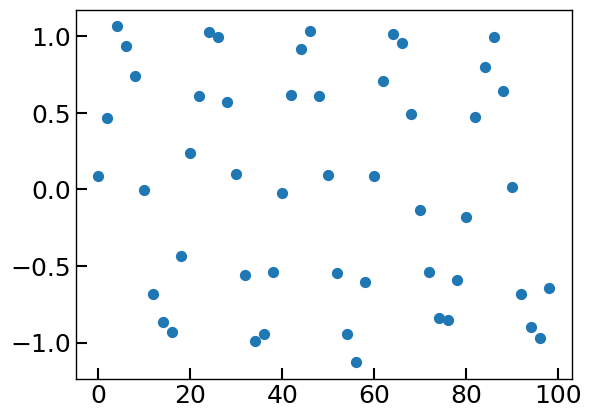

In [70]:
plt.scatter(cadenced_days, cadenced_sig[0], label='Cadenced Signal', s=50)
# plt.plot(times_days, true_sig[0], label='Cadenced Signal')
plt.show()

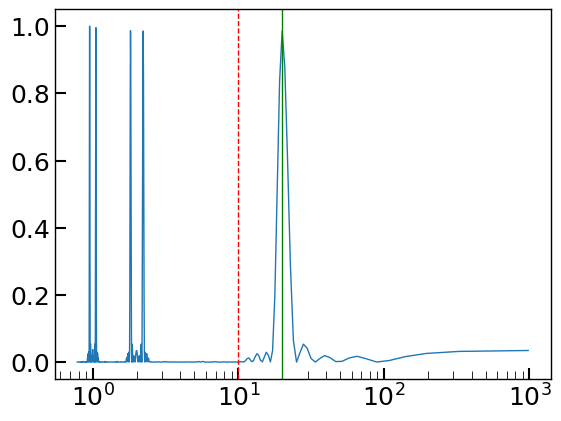

In [72]:
plt.plot(1/frequency, power)
plt.axvline(20/2, color='red', linestyle='--', label='Nyquist period')
plt.axvline(20, label='True Period', color='green')

plt.xscale('log')

plt.show()

Problem 2c : Can you identify the origin of the peaks in the periodogram at periods smaller than the Nyquist limit?
- Compute and plot the periodogram of the window function (by setting the flux value to 1 in `LombScargle`). You may have to also use `fit_mean=False`, and `center_data=False` arguments. We will come back to the meaning of these arguments soon.

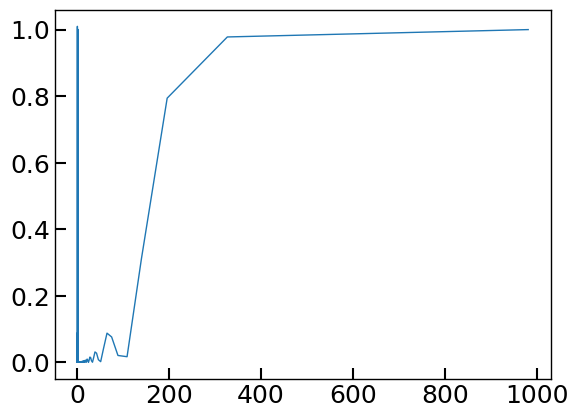

In [73]:
# Plot the periodogram of the window function
# Your code here

ls = LombScargle(cadenced_days, 1, fit_mean=False, center_data=False)

frequency, power = ls.autopower()

plt.plot(1/frequency, power)

Clearly, it does not make sense to compute the periodogram at frequencies larger than the Nyquist limit. Doing so increases the computation time, and the sharp, high peaks will also throw off automated peak-finding algorithms.

To avoid this, it is almost always a good idea to specify the `minimum_frequency` and `maximum_frequency` parameters in the `autopower` method to avoid these peaks. The following are logical recommendations for evenly sampled data :
- `maximum_frequency` = the Nyquist frequency. By default, `LombScargle` sets `maximum_frequency` to 5*the Nyquist frequency, which, for the example above, corresponds to a period of 0.8 days.
- `minimum_frequency` = 1/(Baseline). In practice, setting this to zero or some small value is usually sufficient.

Alternatively, you can provide a full frequency grid on which to compute the periodogram on using the `LombScargle.power` method. The minimum and maximum frequencies can be computed as above, and Van der Plas 2017 recommend a minimum spacing of 1/(Baseline) in order to sample the peaks well.

Problem 2d: Compute the LS periodogram using appropriate frequency limits. Find the best period, defined as the period with the highest value of LS power.

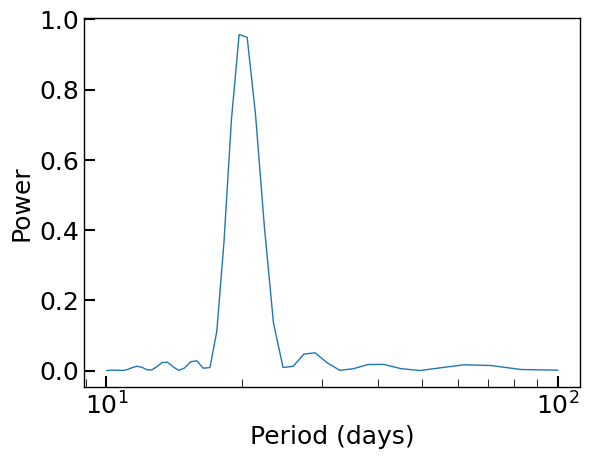

In [75]:
# Compute the Lomb-Scargle periodogram and plot it with appropriate frequency limits
# Your code here

ls = LombScargle(cadenced_days, cadenced_sig[0], cadenced_sig[1])
frequency, power = ls.autopower(minimum_frequency=1/100, maximum_frequency=2/20)

plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

Great, we have gotten rid of the window function peaks! Now, we can identify the peak corresponding to the true period of the signal. The peak at 20 days corresponds to the true period of the signal we simulated.

However, real data is not evenly sampled. What are good choices for `maximum_frequency` for unevenly sampled data? (Note 1/Baseline is still a good choice for `minimum_frequency`, but we cannot define a Nyquist frequency)

Problem 2e: Simulate a sinusoidal signal with amplitude=1.0, period=20.0 days, noise_level=0.1, sampled at 50 random points between 0 and 100 days. Compute the LS periodogram for this, without specifying the `maximum_frequency` parameter.

In [76]:
# Use unevenly sampled data
times_uneven = np.random.uniform(0, 100, 50)  # 50 random time points between 0 and 100 days

cadenced_sig = simulate_sinusoidal_signal(times_uneven, amplitude=1.0, period_days=20, noise_level=0.1)


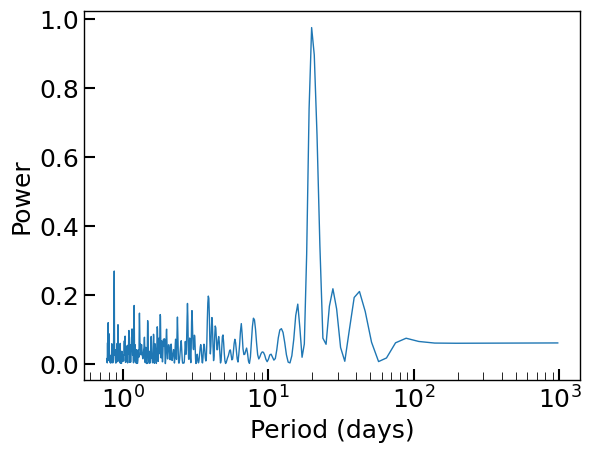

In [77]:
# Compute the Lomb-Scargle periodogram for unevenly sampled data and print the best period

ls = LombScargle(times_uneven, cadenced_sig[0], cadenced_sig[1])
frequency, power = ls.autopower()

plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

What differences do you see from the periodogram of the evenly sampled data? What does that tell you about the Nyquist frequency in the case of unevenly sampled data?

As there are no unphysical, sharp peaks at high frequencies, it seems that we might be able to recover high frequencies with unevenly sampled data. Let us try to recover a period close to the median cadence of our observations.

Problem 2f : Simulate a similar signal as before, but with a period close to the median cadence of the observations. Compute the LS periodogram and the best period. Try with shorter periods.

In [80]:
np.median(np.abs(np.diff(times_uneven)))

26.14561722396651

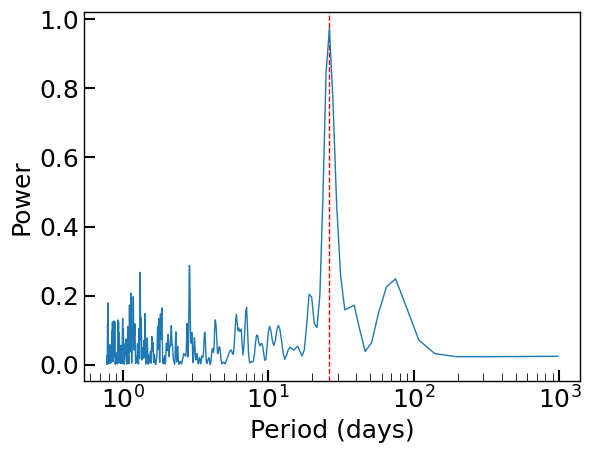

In [82]:
# Calculate the median cadence of the dataset and print it

cadenced_sig = simulate_sinusoidal_signal(times_uneven, amplitude=1.0, period_days=np.median(np.abs(np.diff(times_uneven))), noise_level=0.1)

ls = LombScargle(times_uneven, cadenced_sig[0], cadenced_sig[1])
frequency, power = ls.autopower()

plt.axvline(np.median(np.abs(np.diff(times_uneven))), color='red', linestyle='--', label='Median Cadence')
plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

We can see that the periodogram is able to recover the period even if it is close to the median cadence of the observations.

In fact, unevenly sampled data can often recover much higher frequencies than the median or even the maximum sampling frequencies of the data - something that would be impossible with evenly sampled data.

The downside is that it is not straightforward to define the `maximum_frequency` parameter to compute the `LombScargle` periodogram. This is relevant especially for large datasets, where the periodograms can take a long time to compute and it is important to define an appropriate frequency grid.

Van der Plas (2017) list some options that can be used as proxy-Nyquist frequencies for unevenly sampled data, however, these are almost always very large making the computations intractable.

In practice, the `maximum_frequency` parameter is often set to a reasonable value based on the expected periods of interest, or to a value that is larger than the maximum period of interest.

## 3. Detecting periods in LSST-like data

The above observation has important implications for time-domain surveys, as they can detect periods much lower than their typical cadences. [ZTF has been very successful in finding double white dwarf binaries with periods < 10 minutes, that will be LISA GW sources](https://iopscience.iop.org/article/10.3847/1538-4357/abc261). As we will see in the activities below, progenitors of novae and red-novae can also exhibit very small periods ranging from a few minutes to about a day. ZTF has identified several sources with these periods, despite having a baseline cadence of 2-3 days. 

You may have heard that LSST's cadence will be worse than ZTF, which is a problem for several transient science cases. How does this affect its ability to detect periodicity? Let us examine this. 

LSST will have a semi-uneven cadence. Here is a helper function to get times for simulated LSST observations, accounting for slight cadence differences, downtimes due to weather and solar conjunctions.

In [83]:
def get_lsst_obstimes(mean_cadence_days=6.0, baseline_years=10.0):
    """
    Function to get an array with LSST-like observation times in days,
    with a specified mean cadence, accounting for real-life problems.
    :param mean_cadence_days: float, mean cadence of observations
    :param baseline_years: float, total baseline to get observations for
    :return: times_lsst: np.array, Observation times in days
    """
    times_lsst = np.arange(0, baseline_years*365, mean_cadence_days)  # Sampled every 6 days for 5 years
    times_lsst += np.random.uniform(-1.0/6, 1.0/6, len(times_lsst))  # Add a random offset of +/- four hours
    times_lsst = times_lsst[np.logical_or(0.3 > times_lsst/365 % 1, times_lsst/365 % 1 > 0.7)]  # behind the sun
    times_lsst = times_lsst[np.random.rand(len(times_lsst)) <= 0.7]  # bad weather
    return times_lsst

Problem 3a : Simulate a LSST signal with a period of 200 days, amplitude 10.0, and noise_level=1.0. Compute Lomb-Scargle periodograms for the lightcurve, and the observing window function. Identify the different peaks.

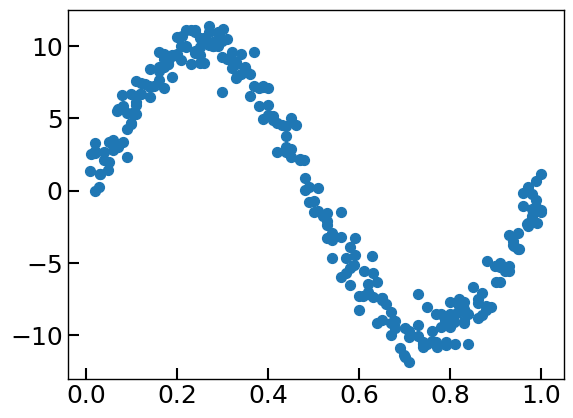

In [88]:
times_lsst = get_lsst_obstimes()
# Your code here

cadenced_sig = simulate_sinusoidal_signal(times_lsst, amplitude=10.0, period_days=200, noise_level=1.0)

plt.scatter(*phase_fold_data(times_lsst, cadenced_sig[0], 200), label='Cadenced Signal', s=50)

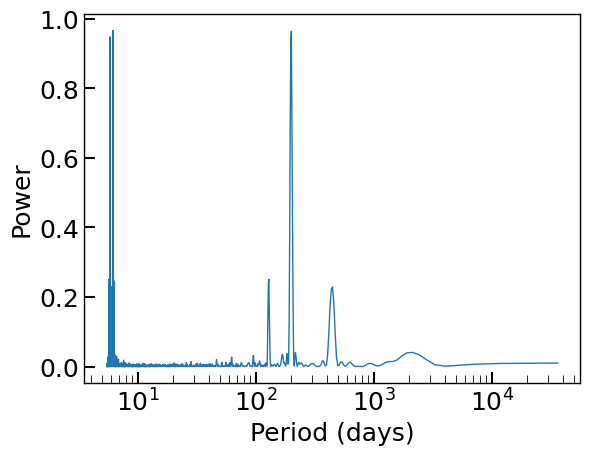

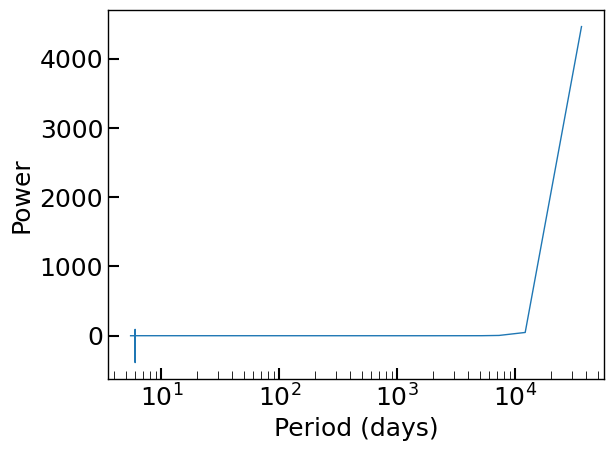

In [90]:
# Compute and plot the Lomb-Scargle periodogram for LSST-like data
# Your code here

ls = LombScargle(times_lsst, cadenced_sig[0], cadenced_sig[1])
frequency, power = ls.autopower()

plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

# Compute and plot the Lomb-Scargle for LSST window function
# Your code here

ls = LombScargle(times_lsst, 1)
frequency, power = ls.autopower()

plt.plot(1/frequency, power)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

Problem 3b: Now let's look at really short periods. As we will see in activity 1, nova progenitors can show periodic modulations with periods as short as 8 minutes. Can we detect these with Rubin? 

- Simulate a LSST-like lightcurve with a period of 8 minutes, amplitude = 10.0, noise_level=1.0. Use a mean cadence of 6 days and baselines of 0.1, 0.5, 1, 2, 5, and 10 years respectively. For each baseline, compute and plot the Lomb-Scargle periodogram for the signals, and print the best period. What do you see?

In [104]:
1/(1./60./24.)/8

180.0

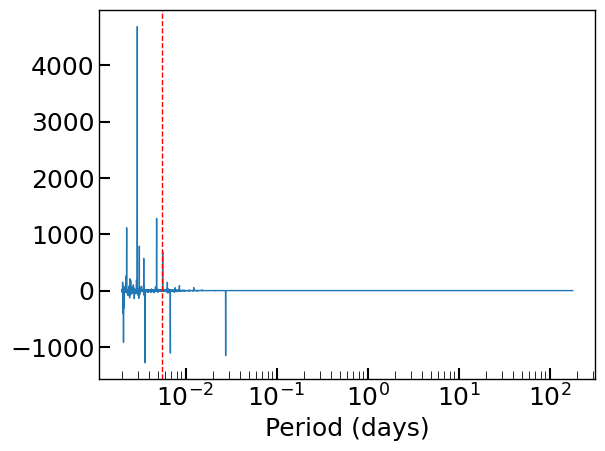

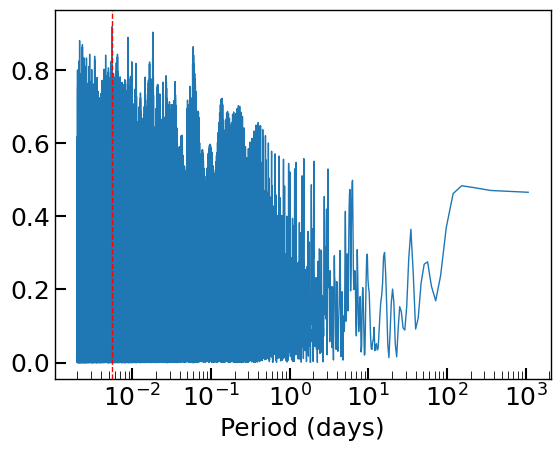

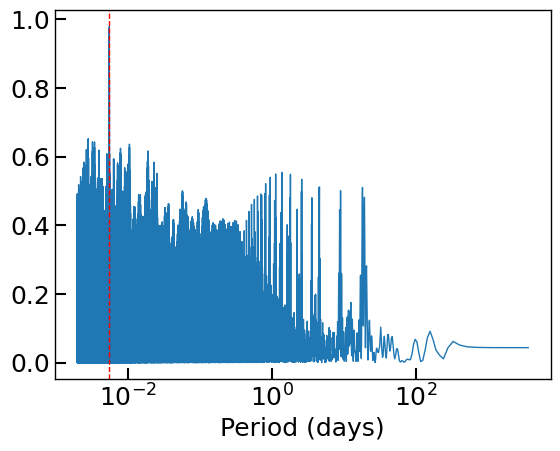

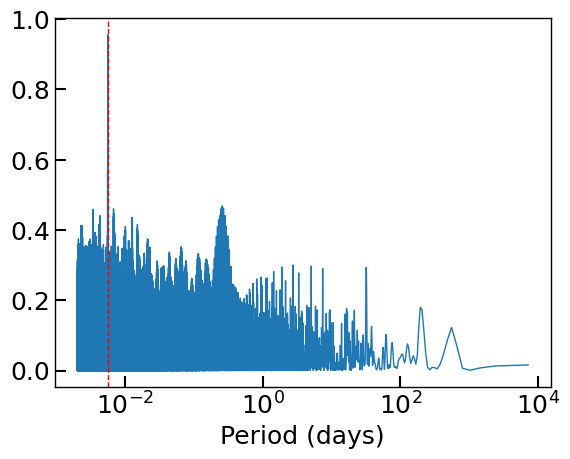

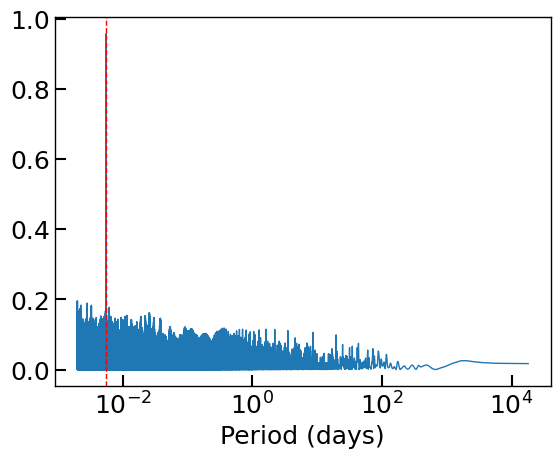

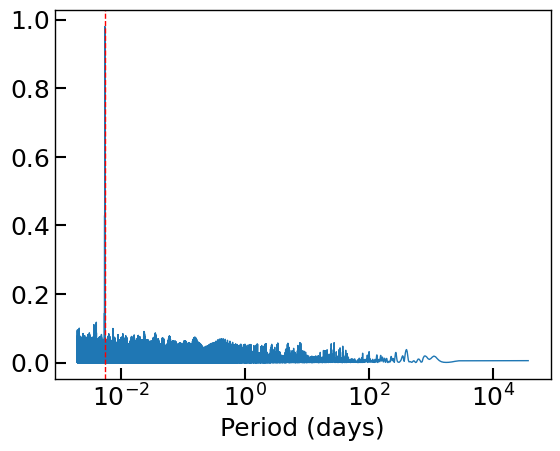

In [105]:
baselines = [0.1, 0.5, 1., 2., 5., 10.]

for baseline in baselines:
    times_lsst = get_lsst_obstimes(mean_cadence_days=6, baseline_years=baseline)
    cadenced_sig = simulate_sinusoidal_signal(times_lsst, amplitude=10.0, period_days=(8 / 60 / 24), noise_level=1.0)
    
    ls = LombScargle(times_lsst, cadenced_sig[0], cadenced_sig[1])
    frequency, power = ls.autopower(maximum_frequency=500)
    
    plt.plot(1/frequency, power, label=f'Baseline {baseline} years')
    plt.axvline(8/60/24, color='red', linestyle='--', label='True Period')
    plt.xscale('log')
    plt.xlabel('Period (days)')
    plt.show()

Problem 3c: Try with a worse cadence. Repeat the above exercise with a cadence of 30 days and baselines of [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0] years

/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/nabeelr/miniforge3/envs/CCA-LSST/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS


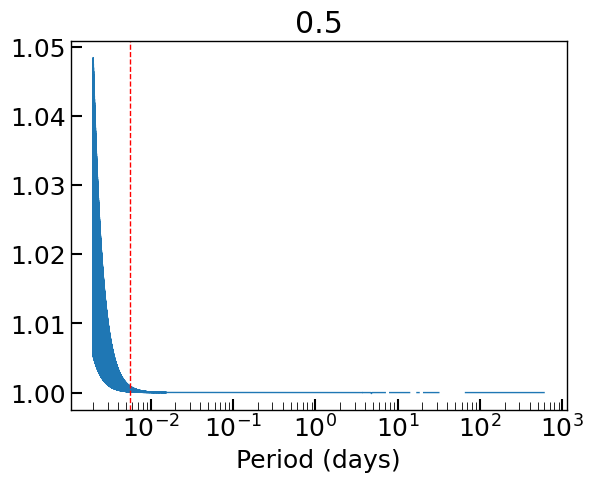

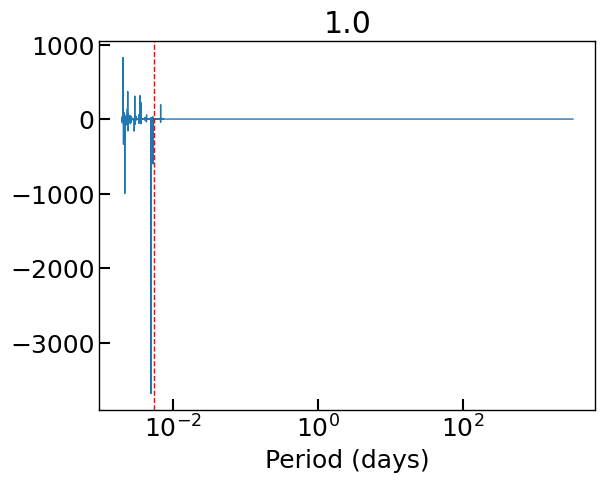

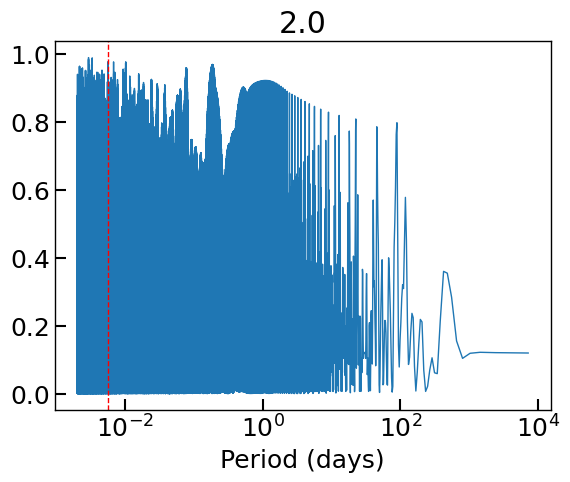

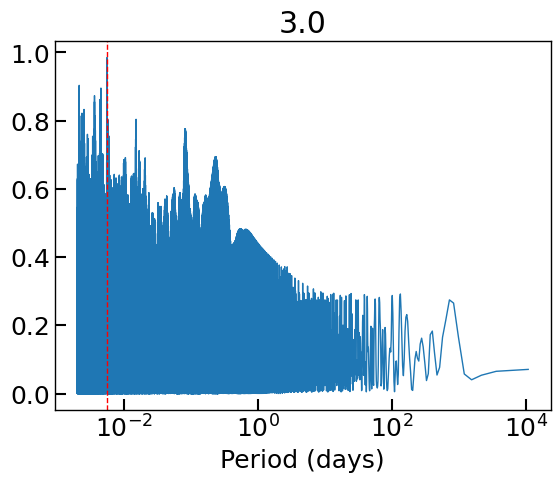

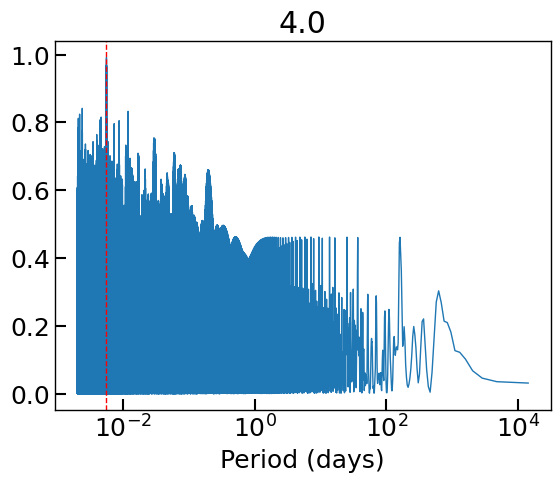

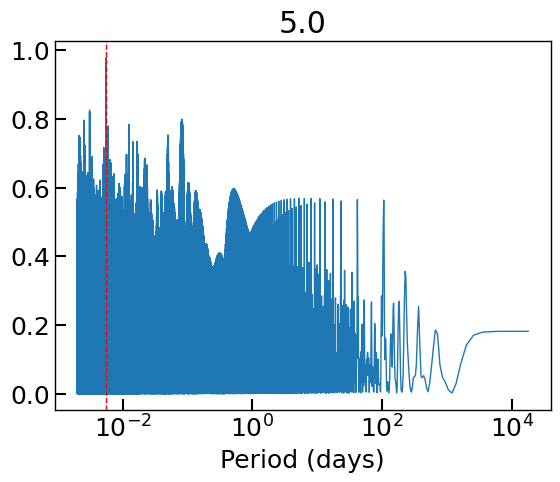

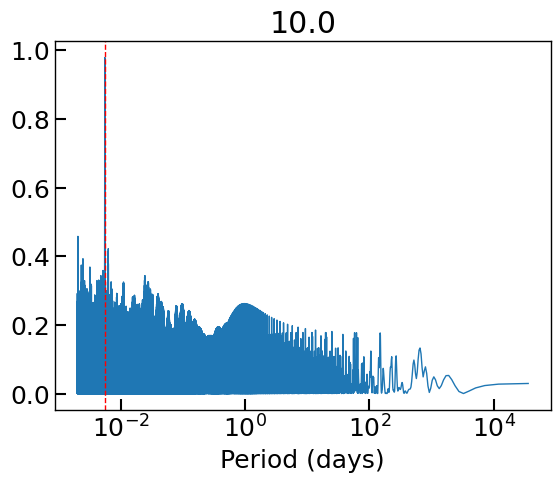

In [108]:
baselines = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0]
for baseline in baselines:
    times_lsst = get_lsst_obstimes(mean_cadence_days=30, baseline_years=baseline)
    cadenced_sig = simulate_sinusoidal_signal(times_lsst, amplitude=10.0, period_days=(8 / 60 / 24), noise_level=1.0)
    
    ls = LombScargle(times_lsst, cadenced_sig[0], cadenced_sig[1])
    frequency, power = ls.autopower(maximum_frequency=500)
    
    plt.title(baseline)
    plt.plot(1/frequency, power, label=f'Baseline {baseline} years')
    plt.axvline(8/60/24, color='red', linestyle='--', label='True Period')
    plt.xscale('log')
    plt.xlabel('Period (days)')
    plt.show()

Problem 3d: Now let's examine the effect of higher noise. Use a cadence of 6 days, baseline of 2 years, an amplitude of 10.0 and noise_levels = [0.01, 0.1, 1, 2, 5]

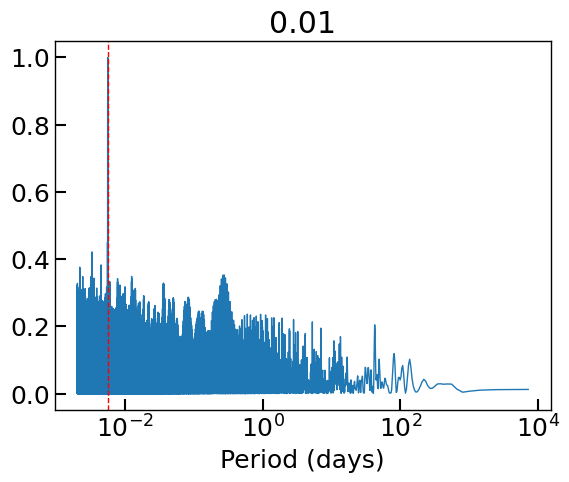

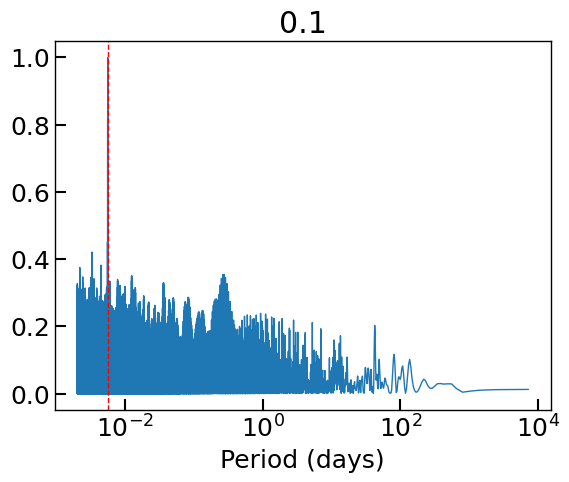

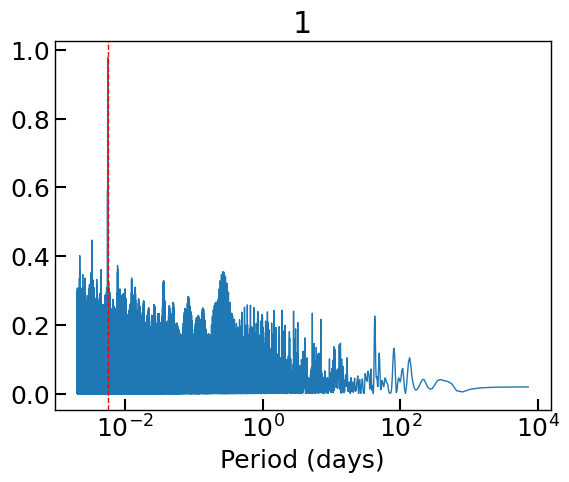

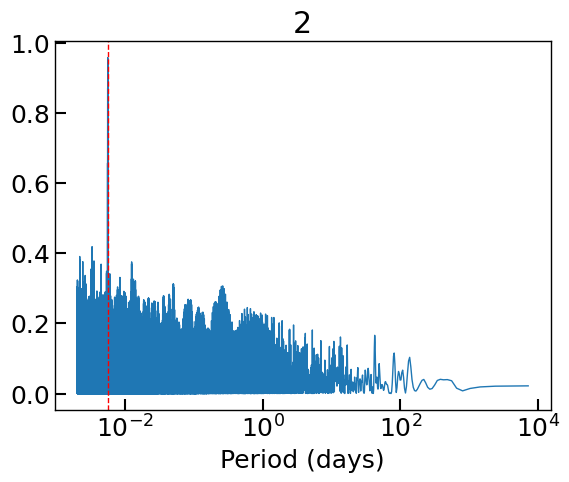

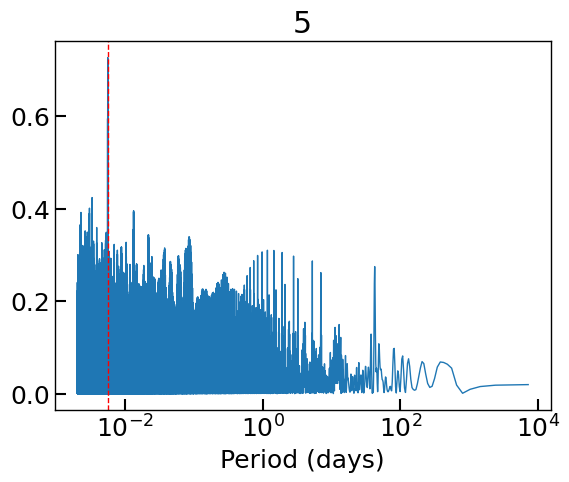

In [109]:
noise_levels = [0.01, 0.1, 1, 2, 5]
times_lsst = get_lsst_obstimes(mean_cadence_days=6.0, baseline_years=2.0)
for noise_level in noise_levels:
    cadenced_sig = simulate_sinusoidal_signal(times_lsst, amplitude=10.0, period_days=(8 / 60 / 24), noise_level=noise_level)
    
    ls = LombScargle(times_lsst, cadenced_sig[0], cadenced_sig[1])
    frequency, power = ls.autopower(maximum_frequency=500)
    
    plt.title(noise_level)
    plt.plot(1/frequency, power)
    plt.axvline(8/60/24, color='red', linestyle='--', label='True Period')
    plt.xscale('log')
    plt.xlabel('Period (days)')
    plt.show()

Problem 3e: What are the main takeaways from this exercise? Think how ZTF vs LSST compares (LSST has a lower cadence + higher precision + goes deeper)

LSST can detect the same short periods that ZTF does, albeit longer baselines will be required. This is fantastic - because LSST goes 4 magnitudes deeper than ZTF, and will detect wayyy more sources than ZTF has.

## 4. LombScargle idiosyncracies

Great! Now before diving into the activities with real data, let us quickly examine some instructive idiosyncracies of the Lomb-Scargle periodogram.

### 4.1 Floating mean periodogram
A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical data, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`).

Let's look at an example to illustrate why this is important for astronomy.

Problem 4a: Simulate a periodic signal as before. Assume uneven sampling. Except now, assume that any signal fainter than -0.5 in our simulated data cannot be detected, so only limit your data to higher values. Then, compute the periods using LombScargle periodograms, once by setting `fit_mean=False` and once by setting `fit_mean=True`. Compare the periods. Plot the lightcurves and sinusoidal fits for both cases.

In [132]:
times = np.linspace(0, 700, 10000)  # Simulate 50 data points from 0 to 100 days
true_sig = simulate_sinusoidal_signal(times, amplitude=10.0, period_days=10, noise_level=0)

times_lsst = get_lsst_obstimes(mean_cadence_days=6.0, baseline_years=2.0)

cadenced_sig = simulate_sinusoidal_signal(times_lsst, amplitude=10.0, period_days=10, noise_level=noise_level)

bright = cadenced_sig[0] > -0.5

bright_sig = (cadenced_sig[0][bright], cadenced_sig[1][bright])
bright_times = times_lsst[bright]

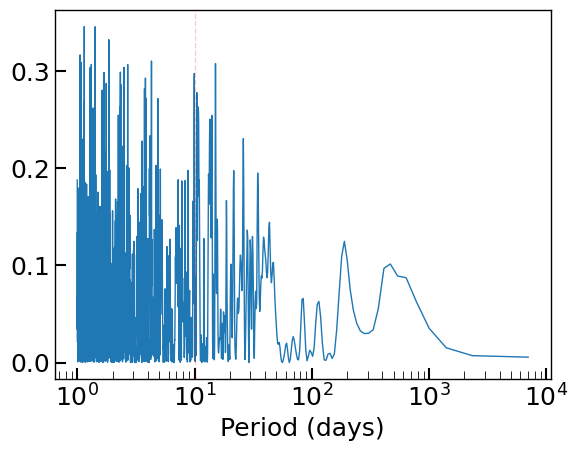

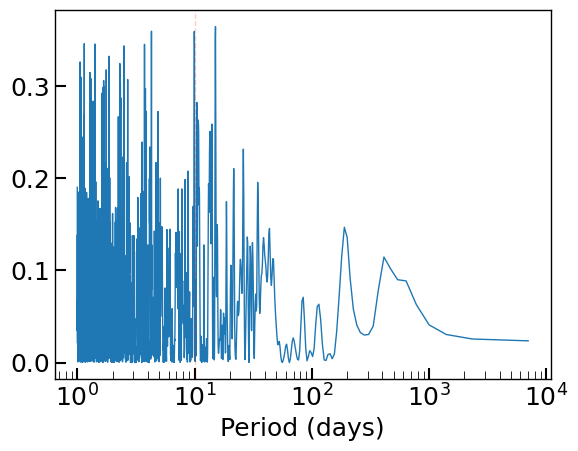

In [133]:
# Plot the periodograms with fit_mean=False and fit_mean = True
ls = LombScargle(bright_times, bright_sig[0], bright_sig[1], fit_mean=False)
frequency, power = ls.autopower(maximum_frequency=1)
plt.plot(1/frequency, power)
plt.axvline(10, color='red', linestyle='--', label='True Period', alpha=0.2)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.show()

ls = LombScargle(bright_times, bright_sig[0], bright_sig[1], fit_mean=True)
frequency, power = ls.autopower(maximum_frequency=1)
plt.plot(1/frequency, power)
plt.axvline(10, color='red', linestyle='--', label='True Period', alpha=0.2)
plt.xscale('log')
plt.xlabel('Period (days)')
plt.show()

(0.0, 100.0)

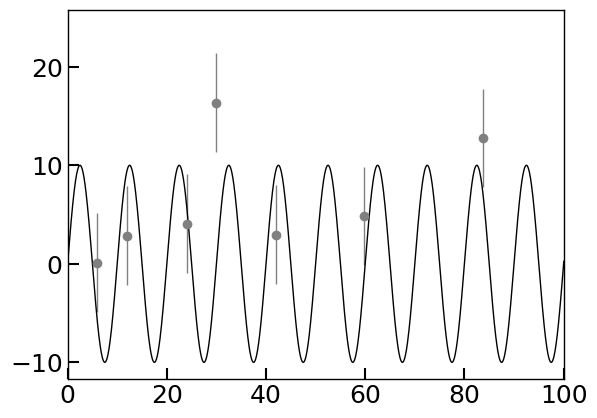

In [128]:
# Overplot the sinusoids on top of the data
plt.errorbar(bright_times, bright_sig[0], yerr=bright_sig[1], fmt='o', label='Bright Data', color='gray')
plt.plot(times, true_sig[0], label='True Signal', color='black')
plt.xlim(0, 100)

### 4.2 Lomb Scargle with Higher harmonics :

Let us try analyzing real ZTF data of an eclipsing binary to find its period.

Problem 4b: Read the ZTF file. Use the helper function provided to convert magnitudes to fluxes. Plot the lightcurve, compute a periodogram, and find the best period. Plot the phase-folded lightcurve.

(FYI : The ztf lightcurve file has been downloaded from the latest ZTF data release from [IRSA](https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?submit=Select&projshort=ZTF) - it represents exactly the kind of data that you would work with for a real science project)

In [129]:
def load_ztf_eclipsing_binary_data(path='files/ztf_eclipsing_binary.fits'):
    lc = Table.read(path)
    lc['fnu_ujy'] = 3631*10**(-0.4*lc['mag']) *1e6
    lc['fnuerr_ujy'] = lc['magerr']/1.086 * lc['fnu_ujy']
    lc = lc[lc['catflags']==0]
    lc.sort('hjd')
    lc = lc[~np.isnan(lc['mag'])]
    lc = lc[(lc['mjd']>58000) & (lc['mjd']<60500)]
    lc = lc[lc['filtercode']=='zr']
    lc['phase'] = lc['mjd'] - lc['mjd'].min()
    return lc


lc_eb = load_ztf_eclipsing_binary_data()

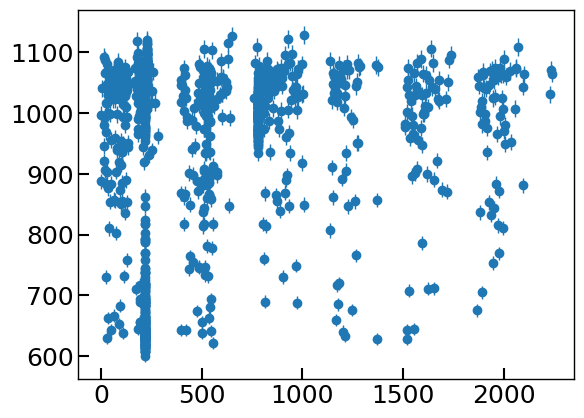

In [130]:
# Plot the lightcurve
plt.errorbar(lc_eb['phase'], lc_eb['fnu_ujy'], yerr=lc_eb['fnuerr_ujy'], fmt='o')
# plt.yscale('log')
plt.show()

In [36]:
# Examine the median cadence between observations
# Your code here

In [37]:
# Compute and plot the Lomb-Scargle periodogram for the ZTF lightcurve
# Your code here

In [38]:
# Phase-fold the lightcurve with this period and plot it
# Your code here


What do you see? The phase-folded lightcurve does not look great.

Problem 4c: Phase fold the lightcurve with twice the best-period.

In [39]:
# Phase fold with twice the period and plot
# Your code here

Looks much better! In fact this shape with two unequal dips is what you expect for an eclipsing binary where a big and small star are orbiting each other.

As Lomb Scargle is essentially a single sinusoid fit to the data, it cannot recover the correct period for sources like this eclipsing binary. This is one of the biggest limitations of `LombScargle`.

In order to recover this, we can modify `LombScargle` by adding more fourier terms to it (see Van der Plas 2017 for a mathematical formulation.)

Problem 4d : Add more harmonic terms using the `nterms` argument to `LombScargle`. Find the new period, plot the phase-folded lightcurve, and plot the best model using `LombScargle.model`

In [41]:
# Add more terms using nterms argument
# Your code here

In [42]:
# Phase fold with the new period
# Your code here

The downside of adding more harmonics is obviously a (much) larger runtime, and the risk of overfitting. In general, you should be very careful in adding more harmonic terms to your algorithms, especially on really large pipelines.

### 4.3 Determining uncertainties on periods

We have found a nice way to determine the periods using LS periodograms. How can we determine their uncertainties?

One attractive option is to measure the width of the peak in the periodogram, and report that as an uncertainty. Let us examine how the width changes with the baseline of observations.

Problem 4e : For baselines of [50, 100, 200, 500, 1000], simulate sinusoidal signals that are sampled at a two-day cadence. Set the amplitude of the signal to 1.0, noise_level to 0.1, and period to 20.0 Calculate the LombScargle periodograms, and examine the width of the peaks as baseline increases.

In [43]:
# Effect of varying the baseline
baselines = [50, 100, 200, 500, 1000]  # Different baselines in days
for baseline in baselines:
    # Your code here
    pass

The width of the Lomb Scargle peak is inversely proportional to the baseline. This method can thus yield a really low (and non-sensical) estimate of the uncertainty especially for long-duration surveys such as LSST.

More importantly, we would also want the uncertainties in the data to influence the uncertainties on the period. Let us examine this for the peak-width method.

Problem 4f : Repeat the above exercise, but this time by varying the noise levels ([0.1, 0.2, 0.5, 1.0]). Use a constant baseline of 100 days.

In [44]:
# Investigate the effect of increasing the noise level
times_uneven = np.random.uniform(0, 100, 50)  # 50 random time points between 0 and 100 days
noise_levels = [0.1, 0.2, 0.5, 1.0]  # Different noise levels
for noise_level in noise_levels:
    # Your code here
    pass

To first order, the width of the periodogram does not depend on the noise level! This is definitely not ideal!!

As described in Van der Plas (2017), there is no silver bullet solution to this problem. The Lomb-Scargle Periodogram provides a nice way to determine the period, but does not provide a natural way to determine its uncertainty.

Often, studies come up with their own ways of reporting uncertainties based on the data that they are looking at. Some common examples include
- Bayesian analysis, computed by fitting sinusoids with periods around the best period to the data.
- Bootstrapping - generating several hundred simulated datasets from the real data by sampling from a Gaussian distribution with the errors, and calculating the best periods from the LS periodograms, and calculating the scatter on the measurements.
- Using methods other than Lomb Scargle, such as , that are  more suited to report uncertainties naturally.

Again, there is no single right answer to this, it depends on the kind of data that you are looking at.

`LombScargle`, does provide a way to report the significance of the period by computing a `false_alarm_probability`, i.e. the probability that a signal with just Gaussian noise and no periodic signals can produce a peak in the spectrogram with the given peak value. We shall skip this for the purposes of this module, but you are highly encouraged to examine `LombScargle.false_alarm_probability` and review Van der Plas (2017) for more details.

Another way of characterizing significance is by injecting fake signals into the survey at various thresholds and seeing how well your code can recover them. This is commonly used for large-scale periodicity searches using data from systematic surveys like ZTF (and will be useful for LSST).



## 5. Beyond `LombScargle`
There are many period-finding methods other than Lomb Scargle!

[Graham et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.434.3423G/abstract) conducted a review of the efficacy of different methods on actual astronomical data.

From Graham et al. 2013, there are three main categories of period-finding methods --

- Those modeling a light curve via a least-squares fit to some set of (orthogonal) basis functions, most commonly trigonometric (LombScargle is in this category).

- Those that phase-fold the data with a large number of trial periods and minimize some measure of the dispersion of time series data in phase space. Examples include binned means (Stellingwerf 1978), Phase Dispersion Minimization (Jurkevich 1971, Stellingwerth 1978), analysis-of-variance (Schwarzenberg-Czerny 1989), total distance between points (Dworetsky 1983), conditional entropy (Graham et al. 2013). Many of these methods do not assume any functional form for the signal, so non-sinusoidal signals can be identified easily. The Conditional Entropy algorithm in particular is known to suprress peaks due to aliasing.

- Those that employ Bayesian inference. Recently, methods have been developed to use Gaussian Process regression to find periods in time-series astronomical signals [Wang et al. 2012](http://adsabs.harvard.edu/abs/2012ApJ...756...67W), [Angus et al. 2018](http://adsabs.harvard.edu/abs/2018MNRAS.474.2094A).

So which method is the best? Graham et al. 2013 found that the answer really depends on the problem at hand, and there is no one method that works well across all cases.

So where is LombScargle useful?

In my (limited) experience of period-finding in large datasets, I have found
- LombScargle is very effective for long period variables (like AGB stars) that have periods larger than $\approx$100 days. Rubin will find many many many of these in the Milky Way and other galaxies.
- LombScargle also works well for pulsating stars with short periods that show sinusoidal-like lightcurve profiles with single-peaks in their phase folded lightcurves (e.g. Cepheids, RR Lyrae, asteroids). However, we need to  be careful about aliasing due to the window function, as the cadences of modern surveys tend to be similar to the periods of these sources.
- LombScargle is not well-suited for eclipsing binaries or other short-period variables that do not show sinusoidal variations (we saw in an eclipsing binary previously) or have multiple humps in their phase-folded lightcurve. Algorithms that do not make assumptions about the pulse profile are better suited for these science cases.

Finally, there are a few different python implementations of the `LombScargle` algorithm.

One of my favourite CPU-based implementation is from [gatspy](https://www.astroml.org/gatspy/). `gatspy` also lets you fit multiband data simultaneously to increase the fidelity of your period. (Be careful though - not all variables have same periodic behaviour in different filters)

[Townsend et al. 2010](https://iopscience.iop.org/article/10.1088/0067-0049/191/2/247) present a GPU implementation for LombScargle.



# Activity 1: Periodicity in a nova

Novae are thermonuclear outbursts that occur on the suface of a white-dwarf as it is accreting gas from a companion. Sometimes, the orbital periodicity of the system is imprinted on the nova outburst and can be detected. In even rare cases, we detect periodic pulsations associated with the spin period of the white dwarf. See [Schaeffer et al. 2021](https://ui.adsabs.harvard.edu/abs/2022MNRAS.517.3640S/abstract) for a recent summary of orbital periods of nova progenitors. Figure 5 shows a histogram of the periods.

In this activity, we will look at the lightcurve of the Nova V1674 Herculis. This nova erupted in 2021, and was special because -

- It is among the top 5% brightest novae found this century
- It is perhaps the fastest nova on record (declined from peak by 2 magnitudes per day)
- Fermi detected a coincident γ-ray source that turned on during the optical peak (Sokolovsky et al. 2023).
- Periodicity was detected in the X-ray and optical light curves just 2 weeks after the optical peak that revealed the orbital period (J. Patterson et al. 2022).
- Preoutburst imaging of the progenitor system by ZTF place tight constraints on the WD spin period prior to outburst (P. Mroz et al. 2021)

The last two points make it interesting for our puposes! We will look at the publicly available data for this nova and try to detect the orbital-period and the spin-period for this source.



First, load the lightcurve of the nova downloaded from [AAVSO](https://www.aavso.org/data-download). While this is some of the most complete data available, it comes with its own issues! Filter the data to focus on the V-band and some quality cuts.

In [45]:
nova_lc = pd.read_csv('files/V1674_her_aavso.dat')
nova_lc_V_band = nova_lc[(nova_lc['Band']=='V')&~np.isnan(nova_lc['Uncertainty']) & (nova_lc['Magnitude']!='<16.2')]


/var/folders/1d/r0f_wd9x10v1pb53kt5hsjg00000gn/T/ipykernel_34995/1370397768.py:1: DtypeWarning: Columns (6,14,20) have mixed types. Specify dtype option on import or set low_memory=False.
  nova_lc = pd.read_csv('files/V1674_her_aavso.dat')


Next, convert the magnitudes to a flux density.

In [64]:
nova_lc_V_band['fnu_jy'] = 3631*10**(-0.4*np.array(nova_lc_V_band['Magnitude'], dtype=float))
nova_lc_V_band['fnuerr_ujy'] = nova_lc_V_band['Uncertainty']/1.086 * nova_lc_V_band['fnu_jy']

<ipython-input-64-8ce95b96f149>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nova_lc_V_band['fnu_jy'] = 3631*10**(-0.4*np.array(nova_lc_V_band['Magnitude'], dtype=float))
<ipython-input-64-8ce95b96f149>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nova_lc_V_band['fnuerr_ujy'] = nova_lc_V_band['Uncertainty']/1.086 * nova_lc_V_band['fnu_jy']


Examine the lightcurve, select a suitable subset of the data, compute the periodogram to determine the best period in the data.

(Note : feel free to experiment with `gatspy` or stick with `LombScargle`)

(Note Note : you may need to detrend the dataset)

In [47]:
# Plot the lightcurve
# Your code here

In [46]:
# Detrend data by fitting a reasonable-order polynomial to the lightcurve data. You can use np.polyfit
 # Your code here

In [48]:
# Compute the Lomb-Scargle periodogram, plot it
# Your code here


In [49]:
# Phase fold the normalized I band magnitudes with the best period
# Your code here

Compare your period and phase-folded curve to that found by [Patterson et al. 2022](https://iopscience.iop.org/article/10.3847/2041-8213/ac9ebe/pdf) or [Schmidt et al. 2021](https://apps.aavso.org/media/jaavso/3780_W9SMx3c.pdf). Note that the data from these papers is not available on AAVSO, so it is not included in your lightcurve!


Now let's look at ZTF data of the nova, that supposedly shows signatures from the spin of the white dwarf. See the associated Astronomer's Telegram [Mroz et al. 2021](https://www.astronomerstelegram.org/?read=14720) for details.

As described in the ATel, the file `Her2021_fps.dat` contains the forced photometry difference lightcurve at the coordinates of the nova. Note that this is photometry performed on difference images, but the nova progenitor is likely present in the reference images as well. Fortunately, we can convert the difference flux into the true science flux by using the `nearestrefmag` values present in the file.

Here are some helper functions that read the ZTF forced photometry file and converts the fluxes into true science fluxes.

In [50]:
def read_ztf_forcedphot_file(filename, use_infobits_flag: bool = True):
    ztflc = ascii.read(filename,format='basic')
    if use_infobits_flag:
        ztflc = ztflc[ztflc['infobitssci,'] == 0]
    try:
        np.array(ztflc['forcediffimflux,'],dtype=float)
    except ValueError:
        ztflc = ztflc[ztflc['forcediffimflux,']!='null']
    #print('Found %s good points.'%(len(ztflc)))
    ztflc['jd'] = np.array(ztflc['jd,'],dtype=float)
    ztflc.add_column(Column(name = 'forcediffimflux_uJy',data=np.array(ztflc['forcediffimflux,'],dtype=float)*10**(-0.4*(np.array(ztflc['zpmaginpsci,'])+48.6))/1e-29))
    ztflc.add_column(Column(name = 'forcediffimfluxunc_uJy',data=np.array(ztflc['forcediffimfluxunc,'],dtype=float)*10**(-0.4*(np.array(ztflc['zpmaginpsci,'])+48.6))/1e-29))
    ztflc['nearestrefmag,'] = np.array(ztflc['nearestrefmag,'],dtype=float)
    ztflc['nearestrefmagunc,'] = np.array(ztflc['nearestrefmagunc,'],dtype=float)
    ztflc_dets = ztflc[ztflc['forcediffimflux_uJy']/ztflc['forcediffimfluxunc_uJy']>3]
    ztflc_lims = ztflc[ztflc['forcediffimflux_uJy']/ztflc['forcediffimfluxunc_uJy']<3]
    gdets = ztflc_dets[ztflc_dets['filter,']=='ZTF_g']
    rdets = ztflc_dets[ztflc_dets['filter,']=='ZTF_r']
    idets = ztflc_dets[ztflc_dets['filter,']=='ZTF_i']

    glims = ztflc_lims[ztflc_lims['filter,']=='ZTF_g']
    rlims = ztflc_lims[ztflc_lims['filter,']=='ZTF_r']
    ilims = ztflc_lims[ztflc_lims['filter,']=='ZTF_i']

    return gdets,rdets,idets,glims,rlims,ilims


def get_reference_included_ztflc(ztflc):
    ztflc['nearestrefflux'] = 10**(0.4*(ztflc['zpdiff,']-ztflc['nearestrefmag,']) )
    ztflc['nearestreffluxunc'] = ztflc['nearestrefmagunc,']*ztflc['nearestrefflux']/1.0857
    ztflc['fluxtot'] = ztflc['nearestrefflux'] + np.array(ztflc['forcediffimflux,'], dtype=float)
    ztflc['fluxtotunc'] = np.sqrt(ztflc['nearestreffluxunc']**2 + np.array(ztflc['forcediffimfluxunc,'], dtype=float)**2)
    ztflc['totmag'] = -2.5*np.log10(ztflc['fluxtot'])+ztflc['zpdiff,']
    ztflc['totmagunc'] = 1.0857*ztflc['fluxtotunc']/ztflc['fluxtot']
    ztflc['totmaglim'] = -2.5*np.log10(5*ztflc['fluxtotunc']) + ztflc['zpdiff,']
    ztflc['fluxtot_uJy'] = 3631*10**(-0.4*ztflc['totmag']) * 1e6
    ztflc['fluxtotunc_uJy'] = ztflc['fluxtot_uJy']*ztflc['totmagunc']/1.0857
    return ztflc


gdets,rdets,idets,glims,rlims,ilims = read_ztf_forcedphot_file('files/V1674_Her_ztf_fps.dat')
rdets = get_reference_included_ztflc(rdets)
rdets['phase'] = rdets['jd'] - rdets['jd'].min()

Examine the lightcurve, select the pre-eruption lightcurve. Compute the periodogram and phase-folded lightcurves to see if you can recover the 8.4 minute period.
(Note : The ATel says there are "differential minima with some scatter due to flickering" - You may need to use multiple harmonics)


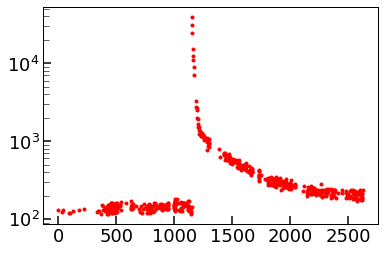

In [48]:
plt.plot(rdets['phase'], rdets['fluxtot_uJy'], '.', color='red')
plt.yscale('log')

In [49]:
# Select and plot precursor data
# Your code here

In [51]:
# Run LombScargle
# Your code here

Note how long the periodogram computation took

In [52]:
# Plot LombSCargle
# Your code here

In [53]:
# phase fold
# Your code here


Looks ok? Note that most of the archival ZTF data is from its routine survey, and is reasonably noisy as the pre-explosion source is faint. The AAVSO data are taken at maximum light, but from a variety of telescopes. Despite this, we were still able to recover the periodic signals.

As an example of what you can do with precise, high-cadence data, see [Patterson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...940L..56P/abstract) who present dedicated observations of this nova that span a total of 1500 hours at a 60 second time resolution. From these observations, they can very precisely and reliably measure both the spin and the orbital periods. They also report detections of changes in the orbital and spin periods. Look at the phase-folded lightcurve for the orbital period from their paper and compare them to ours.

Motivated by this comparison and what you know about LSST, discuss how these measurements will be different in the LSST era. What will be major discovery phases for periodicity searches of nova progenitors?

# Activity 2: Period evolution in the red nova V1309Sco

We have looked at how to detect periodic signals in lightcurves of astrophysical systems. However, several astrophysical systems exhibit periodic signals that change with time. This includes pulsating stars whose periods can change due to physical processes inside the star, or more exotic systems such as binary stars that are spiraling towards each other.

In this part, we will look at one of my favorite astrophysical sources the red nova V1309Sco - a stellar merger in our Milky Way (see [Tylenda et al. 2011](https://www.aanda.org/articles/aa/pdf/2011/04/aa16221-10.pdf)). This source was special because there was extensive archival coverage by the OGLE survey. This showed that the progenitor binary was an eclipsing binary, with a period that was decreasing as the main merger-driven eruption approached. In this activity, you will examine the lightcurve of V1309Sco and examine the changing period. You will also learn about ways to detect periodicity evolution in binary systems.


First, read the lightcurve file, plot the lightcurve, admire it, then restrict it to the pre-outburst phase

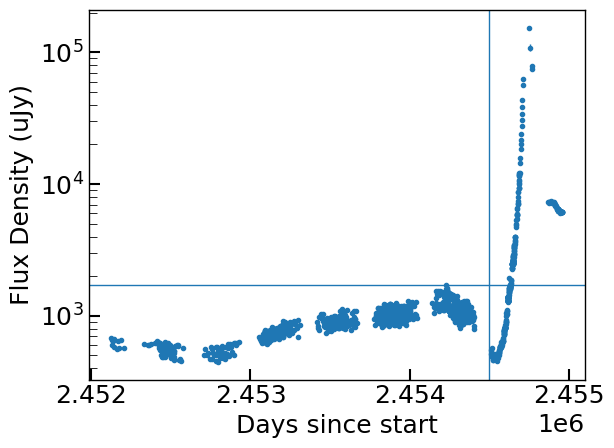

In [145]:
v1309sco_lc = ascii.read('files/v1309sco_OGLE_VEGA_AB.txt')
v1309sco_lc['fnu_ujy'] = v1309sco_lc['Flux']*1e6
v1309sco_lc['fnuerr_ujy'] = v1309sco_lc['Fluxerr']*1e6
v1309sco_lc['phase'] = v1309sco_lc['JD'] - v1309sco_lc['JD'].min()
plt.errorbar(v1309sco_lc['JD'], v1309sco_lc['fnu_ujy'], v1309sco_lc['fnuerr_ujy'], fmt='.')
plt.xlabel(r'Days since start')
plt.ylabel(r'Flux Density (uJy)')
plt.yscale('log')
plt.axvline(2454500)
plt.axhline(1712.0)

In [ ]:
flux[]

1712.0

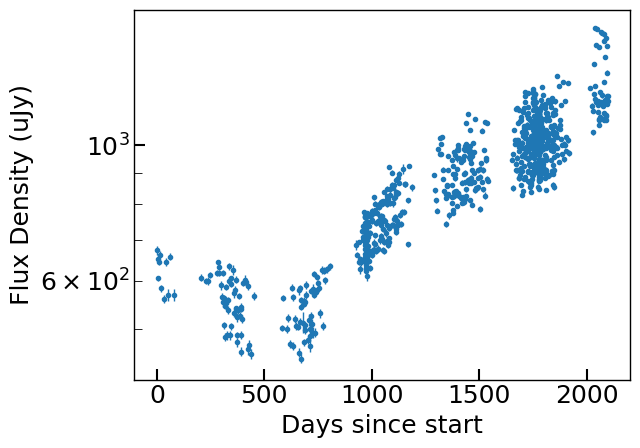

In [147]:
# Select precursor data
# Your code here

time = v1309sco_lc['phase']
flux = v1309sco_lc['fnu_ujy']
flux_unc = v1309sco_lc['fnuerr_ujy']

prec_idx = np.argmax(flux[v1309sco_lc['JD'] < 2454500])

p_time = time[:prec_idx]
p_flux = flux[:prec_idx]
p_flux_unc = flux_unc[:prec_idx]

plt.errorbar(p_time, p_flux, p_flux_unc, fmt='.')
plt.xlabel(r'Days since start')
plt.ylabel(r'Flux Density (uJy)')
plt.yscale('log')

Now plot the precursor lightcurve, divide it into reasonable looking chunks, and compute the orbital periods in each of the chunks. Plot the evolution of period against time - what does it look like?

Some things you might want to consider :
- There is a slow, long-term brightening trend in the precursor lightcurve. This is attributed to outflows from the binary system that is undergoing common-envelope evolution (recall yesterday's lecture). You may want to detrend the lightcurve.
- Recall that LombScaargle runs into issues for eclipsing binary systems.
- Plot the phase-folded lightcurves, and see how the profiles change with time.
- Try to fit an exponential to the period decline curve

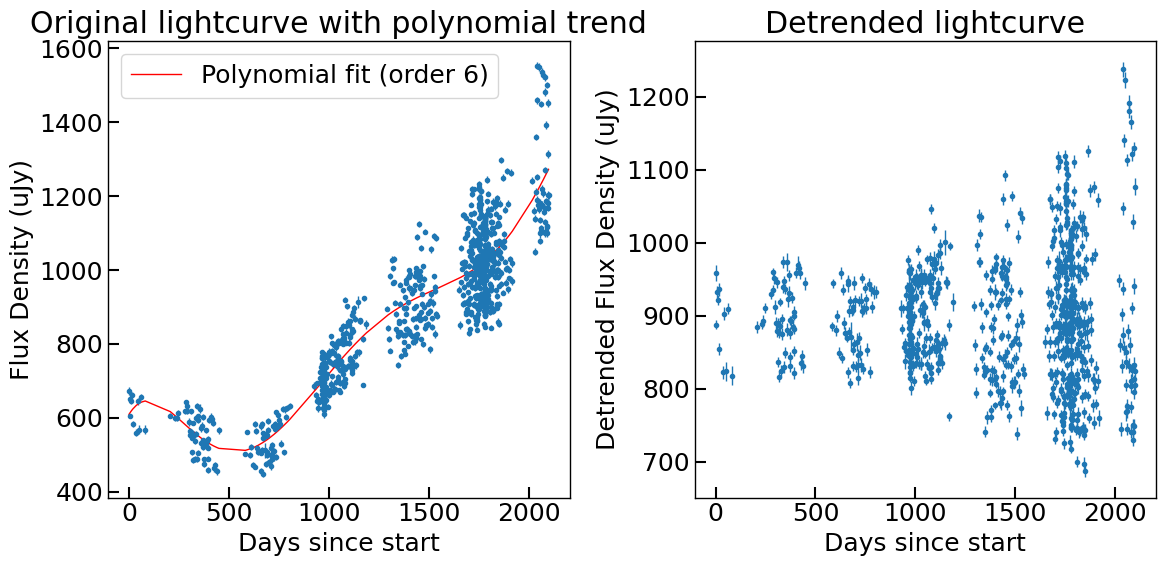

In [184]:
# Detrend lightcurve by fitting a polynomial
# Your code here
# Fit a polynomial to detrend the lightcurve
poly_order = 6  # You can adjust this order as needed
coeffs = np.polyfit(p_time, p_flux, poly_order)
poly_trend = np.polyval(coeffs, p_time)
detrended_flux = p_flux - poly_trend + np.mean(p_flux)

# Plot original and detrended lightcurves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.errorbar(p_time, p_flux, p_flux_unc, fmt='.')
plt.plot(p_time, poly_trend, 'r-', label=f'Polynomial fit (order {poly_order})')
plt.xlabel('Days since start')
plt.ylabel('Flux Density (uJy)')
plt.title('Original lightcurve with polynomial trend')
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(p_time, detrended_flux, p_flux_unc, fmt='.')
plt.xlabel('Days since start')
plt.ylabel('Detrended Flux Density (uJy)')
plt.title('Detrended lightcurve')
plt.tight_layout()
plt.show()


In [186]:
# Divide lc into reasonable looking chunks, and compute period for each chunk
big_gap = np.diff(p_time) > 50

# Find indices where big gaps occur
gap_indices = np.where(big_gap)[0]

# Create chunks based on gaps
chunks = []
start_idx = 0
for gap_idx in gap_indices:
    chunks.append((start_idx, gap_idx + 1))  # +1 to include the point before the gap
    start_idx = gap_idx + 1
# Add the last chunk
chunks.append((start_idx, len(p_time)))

print(f"Found {len(chunks)} chunks")
for i, (start, end) in enumerate(chunks):
    print(f"Chunk {i}: indices {start}-{end}, time range {p_time[start]:.1f} to {p_time[end-1]:.1f} days")
    
chunks = np.array(chunks)

Found 7 chunks
Chunk 0: indices 0-11, time range 0.0 to 81.0 days
Chunk 1: indices 11-63, time range 206.3 to 449.9 days
Chunk 2: indices 63-115, time range 581.3 to 805.0 days
Chunk 3: indices 115-285, time range 926.3 to 1186.9 days
Chunk 4: indices 285-400, time range 1291.3 to 1541.0 days
Chunk 5: indices 400-767, time range 1650.3 to 1917.0 days
Chunk 6: indices 767-813, time range 2016.3 to 2098.2 days


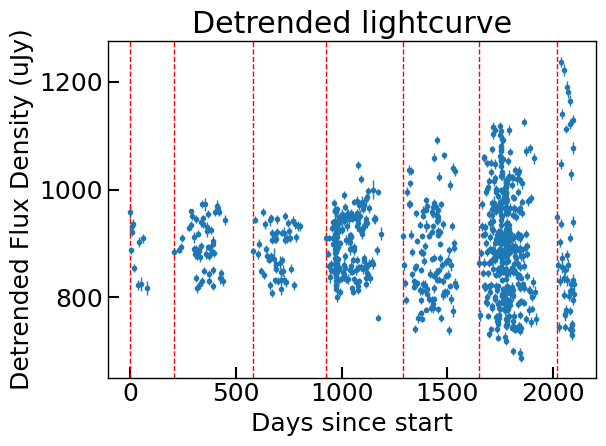

In [187]:

plt.errorbar(p_time, detrended_flux, p_flux_unc, fmt='.')
[plt.axvline(p_time[chunk[0]], color='red', linestyle='--') for chunk in chunks]
plt.xlabel('Days since start')
plt.ylabel('Detrended Flux Density (uJy)')
plt.title('Detrended lightcurve')
plt.tight_layout()
plt.show()

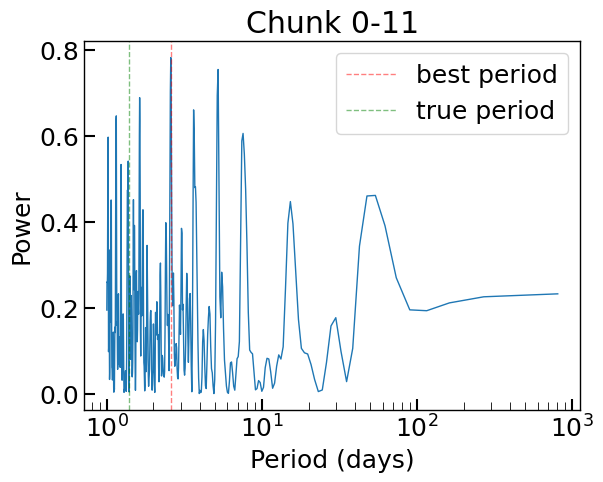

Chunk 0-11: Best period = 2.59 days


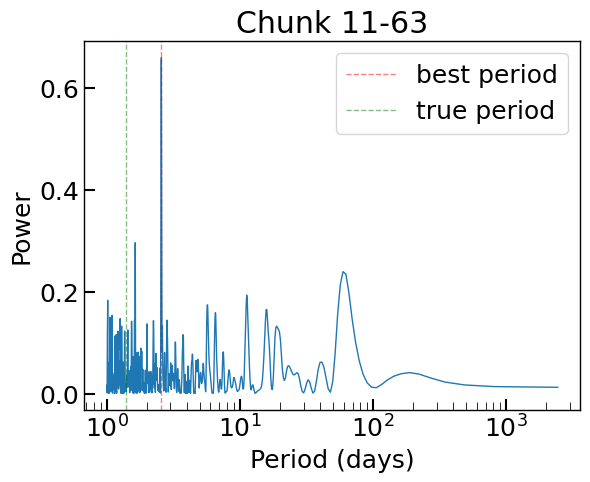

Chunk 11-63: Best period = 2.57 days


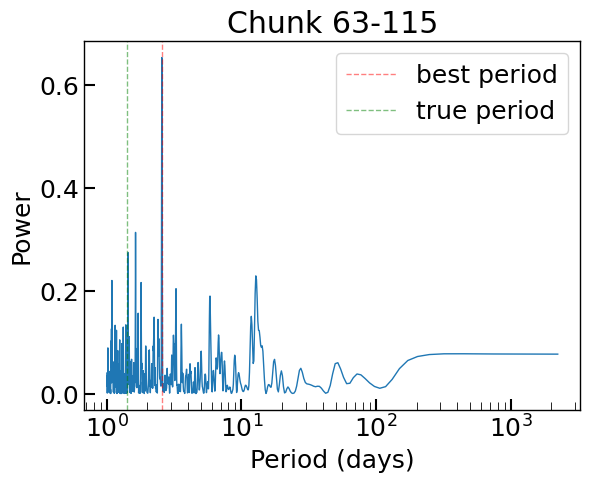

Chunk 63-115: Best period = 2.56 days


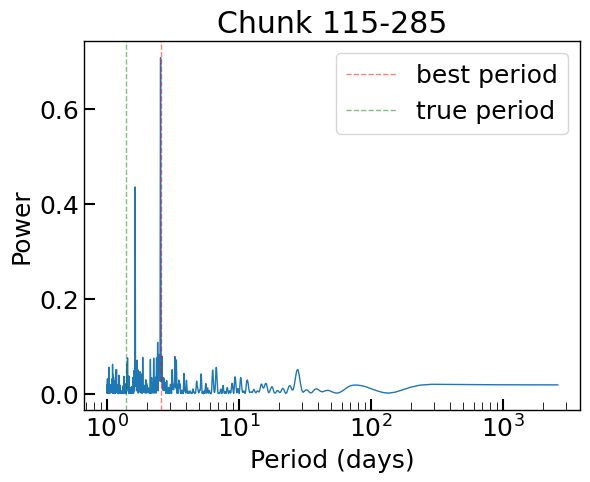

Chunk 115-285: Best period = 2.55 days


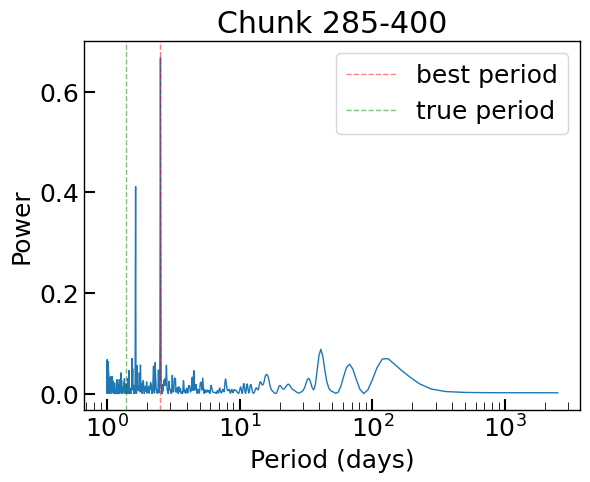

Chunk 285-400: Best period = 2.53 days


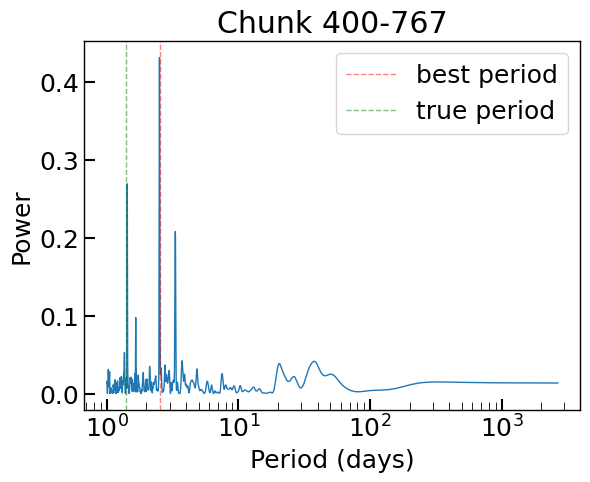

Chunk 400-767: Best period = 2.51 days


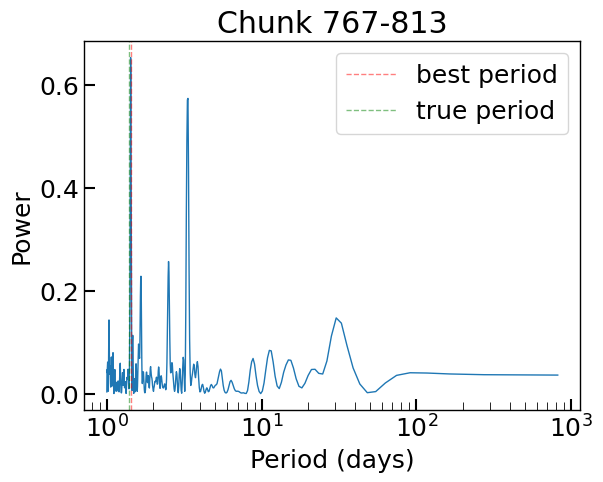

Chunk 767-813: Best period = 1.42 days


In [197]:
best_periods = []
median_chunk_times = []

for chunk in chunks:
    ls = LombScargle(p_time[chunk[0]:chunk[1]], detrended_flux[chunk[0]:chunk[1]], p_flux_unc[chunk[0]:chunk[1]])
    frequency, power = ls.autopower(maximum_frequency=1)
    best_period = 1/frequency[np.argmax(power)]
    best_periods.append(best_period)
    median_chunk_times.append(np.median(p_time[chunk[0]:chunk[1]]))
    
    plt.plot(1/frequency, power)
    plt.xscale('log')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.title(f'Chunk {chunk[0]}-{chunk[1]}')
    plt.axvline(best_period, color='red', linestyle='--', label='best period', alpha=0.5)
    plt.axvline(1.4, color='green', linestyle='--', label='true period', alpha=0.5)
    plt.legend()
    plt.show()
    print(f"Chunk {chunk[0]}-{chunk[1]}: Best period = {best_period:.2f} days")


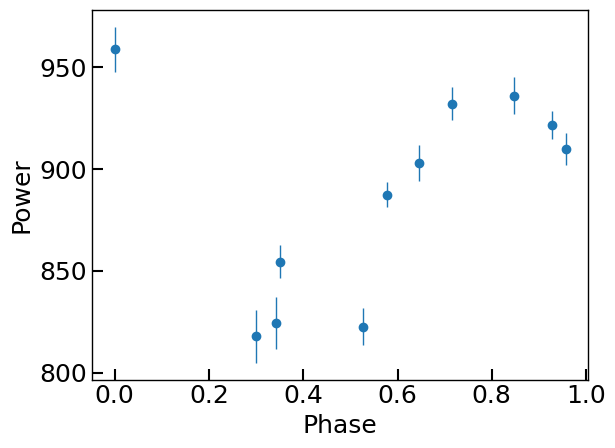

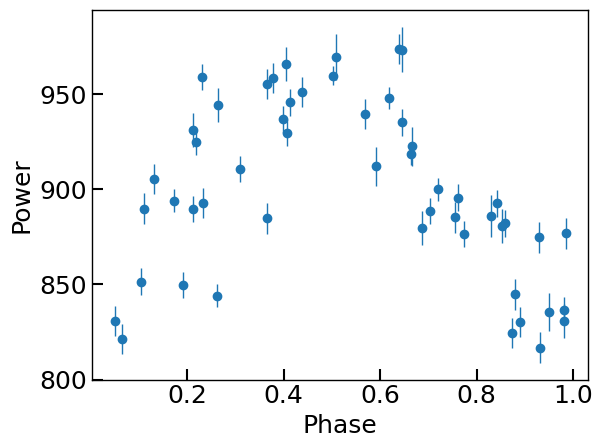

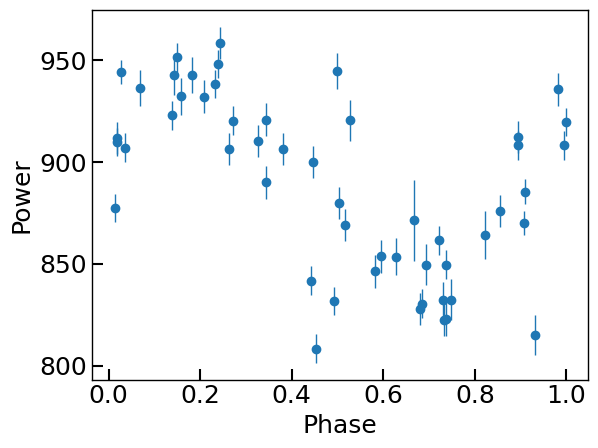

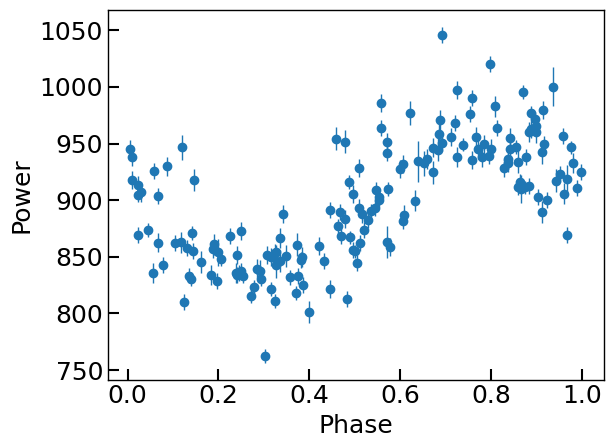

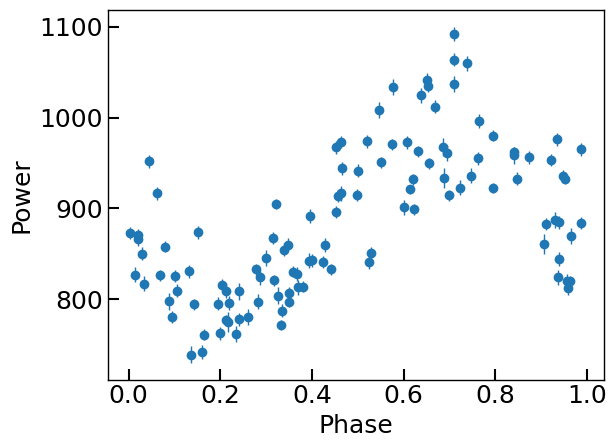

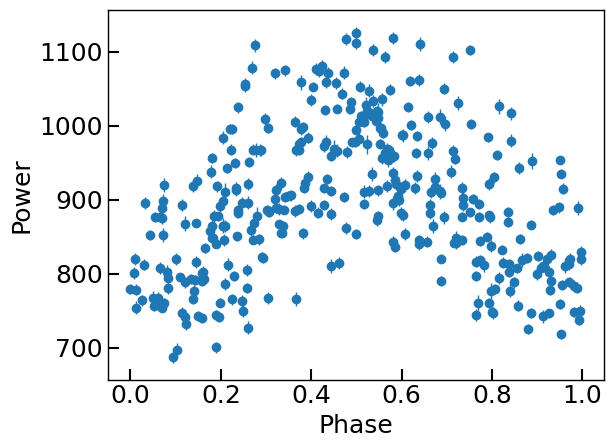

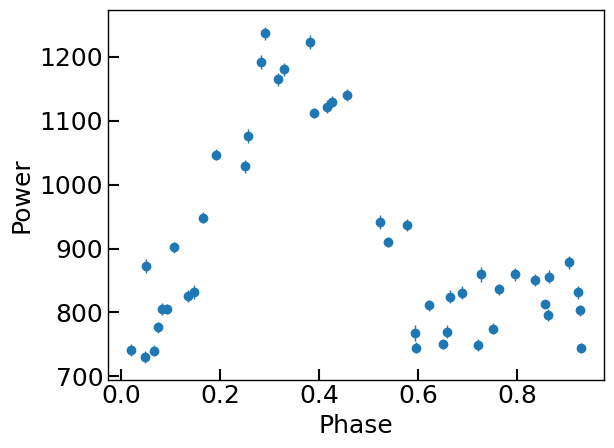

In [195]:
# plot phase folded lightcurves for each chunk

for chunk, best_period in zip(chunks, best_periods):
    p_time[chunk[0]:chunk[1]], detrended_flux[chunk[0]:chunk[1]], p_flux_unc[chunk[0]:chunk[1]]
    phase, folded_flux = phase_fold_data(p_time[chunk[0]:chunk[1]], detrended_flux[chunk[0]:chunk[1]], best_period)
    
    plt.errorbar(phase, folded_flux, p_flux_unc[chunk[0]:chunk[1]], fmt='o')
    plt.xlabel('Phase')
    plt.ylabel('Power')
    plt.show()
    

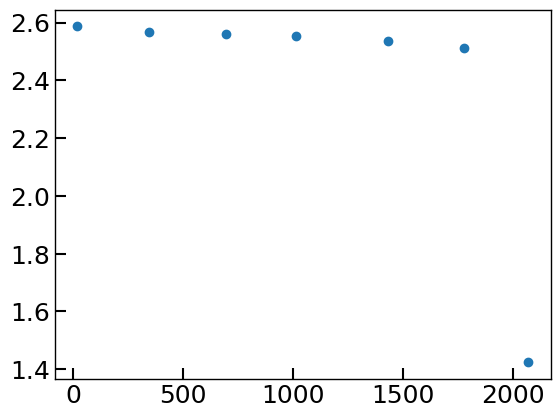

In [196]:
# Plot period as a function of time
# Your code here

plt.scatter(median_chunk_times, best_periods)

The period of this source was decaying exponentially!



# The O-C diagram

The O-C (Observed - Calculated) diagram is a powerful tool for studying periodic signals that change with time. It is used to visualize the difference between the observed times of maximum (or minimum) brightness and the expected times based on a constant period. The O-C diagram can reveal changes in the period of a system over time. To see how the O-C diagram works, let us examine the math.

For a signal with period $P$, the expected time of maximum brightness $T_{\rm{max}}$ is given by:

$T_{\rm{max}} = T_{0} + P(t)N$

where $T_{0}$ is the time of the first maximum, $P(t)$ is the period as a function of time, and $N$ is the number of cycles since $T_{0}$.

We can write the Taylor series expansion of $T_{\rm{max}}$, retaining only up to the quadratic term, as

$T_{\rm{max}} \approx T_{0} + \frac{dT_{\rm{max}}}{dN} (N - N_{0}) + \frac{1}{2} \frac{d^{2}T_{\rm{max}}}{dN^{2}} (N - N_{0})^{2} $

where $N_{0}$ is the number of cycles at $T_{0}$.

$\frac{d^{2}T_{\rm{max}}}{dN^{2}} = \frac{dP}{dN} = \frac{dP}{dt}\frac{dt}{dN} = \dot{P}P$

which gives $T_{\rm{max}} = T_{0} + P(N - N_{0}) + \frac{1}{2} P\dot{P} (N - N_{0})^{2}$

Let us define $O$ as the observed times of maximum brightness, and $C$ as the calculated times of maximum brightness based on a constant period $P_{\rm{calc}}$ that is determined using the Lomb Scargle periodogram or some other method.

$O = T_{\rm{max}}$, and $C = T_{0} + P_{\rm{calc}}(N - N_{0})$

$O - C = (P - P_{\rm{calc}})(N - N_{0}) + \frac{1}{2}P\dot{P}(N - N_{0})^{2}$

$O - C = \Delta P (N - N_{0}) + \frac{1}{2}P\dot{P}(N - N_{0})^{2} $ where $\Delta P$ is the discrepancy between the true and estimated period.

If there is no period evolution, $O - C \propto N$ : the O-C diagram will be a straight line with slope $\Delta P$.

If the period is changing at a constant rate, $O - C \propto N^{2}$  : the O-C diagram will be a parabola with curvature $P\dot{P}$.

Thus, the shape of the $O-C$ curve can be used to determine whether the period is changing and the rate at which it is changing.
- Increasing period will result in a positive curvature (i.e. the parabola opens upwards), while a decreasing period will result in a negative curvature (i.e. the parabola opens downwards).
- A steeper curvature implies a faster rate of change.

Note : The O-C curve name comes from the world of variable (single) stars. In the binary land, it is also referred to as a eclipse time variation (ETV) or eclipse time drift curve.

Here is the O-C curve for V1309Sco, from [Molnar et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...840....1M/abstract), calculated relative to the period in the middle part of the precursor observations.

![Figure 2 from https://ui.adsabs.harvard.edu/abs/2017ApJ...840....1M/abstract](files/v1309sco_oc_curve.png)

Examine this curve. Is it what you would expect from the exponential decline derived in the previous part?

V1309Sco is one of a kind - there is no other confirmed binary system with a decreasing period that will merge soon. Ideate how you could set up a systematic search for such systems in a large dataset like ZTF or LSST. What could be potential challenges in doing this?

### Bonus problem : Compute the O-C curve for V1309Sco.